# Trabalho prático de Elementos de inteligencia artificial


In [51]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import os

from bs4 import BeautifulSoup
from distritos import dicionario_distritos
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

## Recolha de Dados

In [52]:
LINKS = [
    "https://www.pordata.pt/pt/estatisticas/saude/pessoal-de-saude/pessoal-ao-servico-nos-hospitais-portugal",
    "https://www.pordata.pt/pt/estatisticas/populacao/esperanca-de-vida-e-obitos/taxa-bruta-de-mortalidade-0",
    "https://www.pordata.pt/pt/estatisticas/populacao/nascimentos-e-fecundidade/taxa-bruta-de-natalidade-0"
]

dataframes: dict[str, pd.DataFrame] = {
    "pessoal-servico": None,
    "mortalidade": None,
    "natalidade": None
}

c = -1
for url in LINKS:
    c += 1
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Erro ao tentar acessar ao site: {url}")
        continue
    
    soup = BeautifulSoup(response.text, "html.parser")

    download_btn = soup.find("a", id="download-btn")

    if not download_btn or not download_btn.has_attr("href"):
        print(f"Erro ao tentar acessar o csv do link {url}")
        continue
    
    match c:
        case 0:
            dataframes["pessoal-servico"] = pd.read_csv(download_btn["href"])
        case 1:
            dataframes["mortalidade"] = pd.read_csv(download_btn["href"])
        case 2:
            dataframes["natalidade"] = pd.read_csv(download_btn["href"])

## Integração de Dados

#### Pessoal ao serviço nos hospitais

In [53]:
# Deixar só os municipios e apagar dados gerais nacionais
dataframes["pessoal-servico"] = dataframes["pessoal-servico"].dropna(subset=["03. Âmbito Geográfico"])

#Apagar colunas futeis
dataframes["pessoal-servico"] = dataframes["pessoal-servico"].drop(columns=["03. Âmbito Geográfico", "06. Filtro 2", "07. Filtro 3", "08. Escala", "09. Símbolo"])

#Mudar nome das colunas
dataframes["pessoal-servico"] = dataframes["pessoal-servico"].rename(columns={"01. Ano": "Ano",
                                                                              "02. Nome Região (Portugal)": "Nome Municipio",
                                                                              "04. Indicador": "Tipo de Hospital",
                                                                              "05. Filtro 1": "Tipo de Pessoal Medico",
                                                                              "10. Valor": "Quantidade de Pessoal Medico"
                                                                              })

#Mudar o tipo da coluna do ano para um numero inteiro
dataframes["pessoal-servico"][dataframes["pessoal-servico"].columns[0]] = dataframes["pessoal-servico"][dataframes["pessoal-servico"].columns[0]].astype(int)

#Separar tipo de pessoal medico
dataframes["pessoal-servico"] = dataframes["pessoal-servico"].pivot_table(
    index=["Ano", "Nome Municipio", "Tipo de Hospital"],
    columns="Tipo de Pessoal Medico",
    values="Quantidade de Pessoal Medico",
    aggfunc="sum"
).reset_index()

# Remover primeira coluna criada depois do pivot
dataframes["pessoal-servico"].columns.name = None

#Reordenar as colunas
dataframes["pessoal-servico"] = dataframes["pessoal-servico"][["Ano", "Nome Municipio", "Tipo de Hospital", "Enfermeiros",
                                                               "Médicos", "Pessoal auxiliar", "Técnicos de diagnóstico e terapêutica",
                                                               "Outros", "Total"
                                                              ]]

display(dataframes["pessoal-servico"].head(100))

Ano               Nome Municipio Tipo de Hospital  Enfermeiros  Médicos  \
0   2002                     Abrantes        Hospitais        207.0     73.0   
1   2002              Aguiar da Beira        Hospitais          0.0      0.0   
2   2002                    Alandroal        Hospitais          0.0      0.0   
3   2002           Albergaria-a-Velha        Hospitais          0.0      0.0   
4   2002                    Albufeira        Hospitais          0.0      0.0   
..   ...                          ...              ...          ...      ...   
95  2002           Ferreira do Zêzere        Hospitais          0.0      0.0   
96  2002              Figueira da Foz        Hospitais        188.0    104.0   
97  2002  Figueira de Castelo Rodrigo        Hospitais          0.0      0.0   
98  2002          Figueiró dos Vinhos        Hospitais          0.0      0.0   
99  2002           Fornos de Algodres        Hospitais          0.0      0.0   

    Pessoal auxiliar  Técnicos de diagnóstico e terapêutica  Outros  Total  
0              159.0                                   34.0   132.0  605.0  
1                0.0                                    0.0     0.0    0.0  
2                0.0                                    0.0     0.0    0.0  
3                0.0                                    0.0     0.0    0.0  
4                0.0                                    0.0     0.0    0.0  
..               ...                                    ...     ...    ...  
95               0.0                                    0.0     0.0    0.0  
96             114.0                                   48.0   133.0  587.0  
97               0.0                                    0.0     0.0    0.0  
98               0.0                                    0.0     0.0    0.0  
99               0.0                                    0.0     0.0    0.0  

[100 rows x 9 columns]

#### Taxa Bruta de Mortalidade

In [54]:
# Deixar só os municipios e apagar dados gerais nacionais
dataframes["mortalidade"] = dataframes["mortalidade"].dropna(subset=["04. Âmbito Geográfico"])

#Apagar colunas futeis
dataframes["mortalidade"] = dataframes["mortalidade"].drop(columns=["02. Nome País (Europa)", "04. Âmbito Geográfico", "05. Filtro 1", "06. Filtro 2", "07. Filtro 3", "08. Escala", "09. Símbolo"])

#Mudar nome das colunas
dataframes["mortalidade"] = dataframes["mortalidade"].rename(columns={"01. Ano": "Ano",
                                                                      "03. Nome Região (Portugal)": "Nome Municipio",
                                                                      "10. Valor": "Taxa Bruta de Mortalidade (‰)"
                                                                    })

#Mudar o tipo da coluna do ano para um numero inteiro
dataframes["mortalidade"][dataframes["mortalidade"].columns[0]] = dataframes["mortalidade"][dataframes["mortalidade"].columns[0]].astype(int)

display(dataframes["mortalidade"].head(100))

Ano               Nome Municipio  Taxa Bruta de Mortalidade (‰)
1792  1996                     Abrantes                           14.5
1793  1996                       Águeda                            8.7
1794  1996              Aguiar da Beira                           17.0
1795  1996                    Alandroal                           15.5
1796  1996           Albergaria-a-Velha                            9.0
...    ...                          ...                            ...
1887  1996                   Felgueiras                            6.4
1888  1996         Ferreira do Alentejo                           14.2
1889  1996           Ferreira do Zêzere                           17.1
1890  1996              Figueira da Foz                           12.2
1891  1996  Figueira de Castelo Rodrigo                           17.1

[100 rows x 3 columns]

#### Taxa Bruta de Natalidade

In [55]:
# Deixar só os municipios e apagar dados gerais nacionais
dataframes["natalidade"] = dataframes["natalidade"].dropna(subset=["04. Âmbito Geográfico"])

#Apagar colunas futeis
dataframes["natalidade"] = dataframes["natalidade"].drop(columns=["02. Nome País (Europa)", "04. Âmbito Geográfico", "05. Filtro 1", "06. Filtro 2", "07. Filtro 3", "08. Escala", "09. Símbolo"])

#Mudar nome das colunas
dataframes["natalidade"] = dataframes["natalidade"].rename(columns={"01. Ano": "Ano",
                                                                    "03. Nome Região (Portugal)": "Nome Municipio",
                                                                    "10. Valor": "Taxa Bruta de Natalidade (‰)",
                                                                    })


#Mudar o tipo da coluna do ano para um numero inteiro
dataframes["natalidade"][dataframes["natalidade"].columns[0]] = dataframes["natalidade"][dataframes["natalidade"].columns[0]].astype(int)

dataframes["natalidade"].head(100)

Ano               Nome Municipio  Taxa Bruta de Natalidade (‰)
1792  1995                     Abrantes                           7.0
1793  1995                       Águeda                          10.6
1794  1995              Aguiar da Beira                           9.0
1795  1995                    Alandroal                           6.3
1796  1995           Albergaria-a-Velha                          10.7
...    ...                          ...                           ...
1887  1995                   Felgueiras                          16.7
1888  1995         Ferreira do Alentejo                           7.7
1889  1995           Ferreira do Zêzere                           6.3
1890  1995              Figueira da Foz                           9.1
1891  1995  Figueira de Castelo Rodrigo                           6.0

[100 rows x 3 columns]

#### Conjugação dos csv"s

In [56]:
#Remoção das colunas com os valores inferiores a 2002, pois o pessoal medico não tem valores sobre tais anos
dataframes["mortalidade"] = dataframes["mortalidade"][dataframes["mortalidade"]["Ano"] >= 2002]
dataframes["natalidade"] = dataframes["natalidade"][dataframes["natalidade"]["Ano"] >= 2002]

#Remoção das colunas com os valores de 2024 da mortalidade, pois tanto a natalidade quando o pessoal não tem desse ano
dataframes["mortalidade"] = dataframes["mortalidade"][dataframes["mortalidade"]["Ano"] < 2024]
display(dataframes["pessoal-servico"].head())


df_final = pd.merge(dataframes["pessoal-servico"], dataframes["mortalidade"])
df_final = pd.merge(df_final, dataframes["natalidade"])

Ano      Nome Municipio Tipo de Hospital  Enfermeiros  Médicos  \
0  2002            Abrantes        Hospitais        207.0     73.0   
1  2002     Aguiar da Beira        Hospitais          0.0      0.0   
2  2002           Alandroal        Hospitais          0.0      0.0   
3  2002  Albergaria-a-Velha        Hospitais          0.0      0.0   
4  2002           Albufeira        Hospitais          0.0      0.0   

   Pessoal auxiliar  Técnicos de diagnóstico e terapêutica  Outros  Total  
0             159.0                                   34.0   132.0  605.0  
1               0.0                                    0.0     0.0    0.0  
2               0.0                                    0.0     0.0    0.0  
3               0.0                                    0.0     0.0    0.0  
4               0.0                                    0.0     0.0    0.0

#### Adição da coluna de distrito

In [57]:
#Adição da coluna de distrito
df_final["Distrito"] = df_final["Nome Municipio"].map(dicionario_distritos)

#Reodenação para por a coluna de distrito em segundo
df_final = df_final[["Ano", "Distrito", "Nome Municipio", 
                     "Tipo de Hospital", "Enfermeiros", "Médicos",
                     "Pessoal auxiliar", "Técnicos de diagnóstico e terapêutica",
                     "Outros","Total", "Taxa Bruta de Mortalidade (‰)",
                     "Taxa Bruta de Natalidade (‰)"
                    ]]

df_final.to_csv("distritos.csv", index=False)

#### Restrição para apenas coluna de distrito

In [58]:
# Remoção da coluna de municipio
df_final = df_final.drop(columns=["Nome Municipio"])

# Agrupação das colunas pelo ano e distrito
df_final = df_final.groupby(["Ano", "Distrito"], as_index=False).agg({
    "Enfermeiros": "sum",
    "Médicos": "sum",
    "Pessoal auxiliar": "sum",
    "Técnicos de diagnóstico e terapêutica": "sum",
    "Outros": "sum",
    "Total": "sum",
    "Taxa Bruta de Mortalidade (‰)": "mean",
    "Taxa Bruta de Natalidade (‰)": "mean"
})

df_final.head(100)

df_final.to_csv("final.csv", index=False)

# Análise Exploratória

#### Verificar valores duplicados

In [59]:
print("Linhas duplicadas:", int(df_final.duplicated().sum()))

Linhas duplicadas: 0


#### Verificar valores em falta

In [60]:
print("Colunas com valores em falta:")
display(df_final.isnull().sum())

Colunas com valores em falta:


Ano                                      0
Distrito                                 0
Enfermeiros                              0
Médicos                                  0
Pessoal auxiliar                         0
Técnicos de diagnóstico e terapêutica    0
Outros                                   0
Total                                    0
Taxa Bruta de Mortalidade (‰)            0
Taxa Bruta de Natalidade (‰)             0
dtype: int64

#### Matriz de correlação das colunas

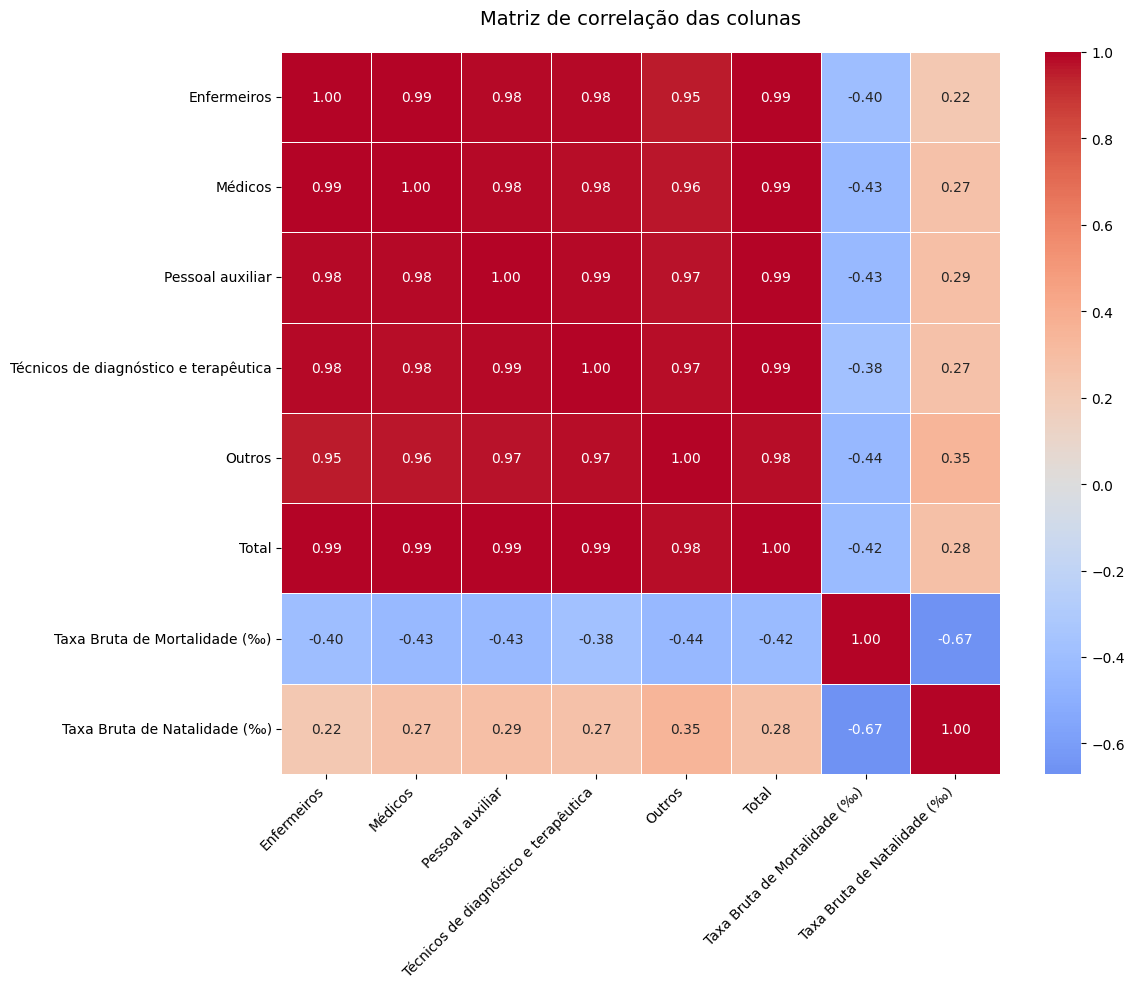

In [61]:
matriz_corelacao = df_final[[
    'Enfermeiros', 'Médicos', 'Pessoal auxiliar',
    'Técnicos de diagnóstico e terapêutica', 'Outros', 'Total',
    'Taxa Bruta de Mortalidade (‰)', 'Taxa Bruta de Natalidade (‰)'
]].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(matriz_corelacao, 
           annot=True, 
           fmt=".2f", 
           cmap='coolwarm', 
           center=0,
           linewidths=0.5,
           annot_kws={"size": 10})

plt.title("Matriz de correlação das colunas", pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

#### Gráficos de evolução das variaveis

Pasta 'graficos_evolucao_metricas' criada para guardar o gráfico.

Gráfico da Evolução do Total de Pessoal de Saúde guardado como: graficos_evolucao_metricas\evolucao_total_pessoal_saude_por_distrito.png


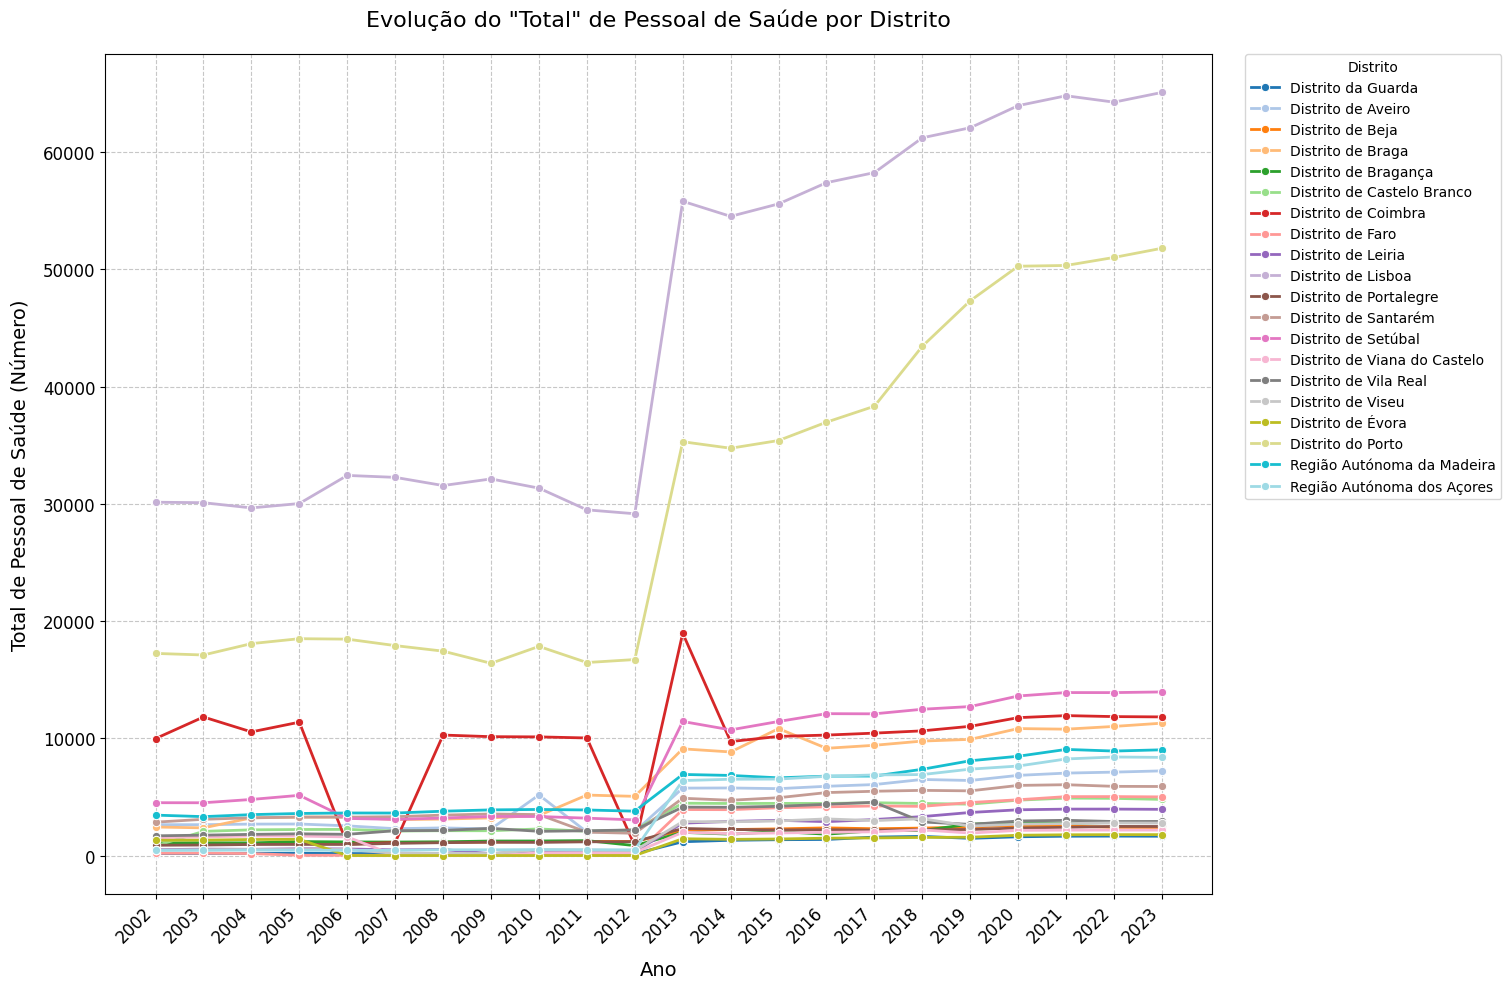

In [62]:
metrica_total_pessoal = 'Total'
palette_distritos = 'tab20'

pasta_graficos_evolucao = "graficos_evolucao_metricas"
if not os.path.exists(pasta_graficos_evolucao):
    os.makedirs(pasta_graficos_evolucao)
    print(f"Pasta '{pasta_graficos_evolucao}' criada para guardar o gráfico.")

fig, ax = plt.subplots(figsize=(18, 10)) 

sns.lineplot(data=df_final, x='Ano', y=metrica_total_pessoal, hue='Distrito', marker='o', linewidth=2, palette=palette_distritos, ax=ax)

ax.legend(title='Distrito', bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0., fontsize=10)
ax.set_title(f'Evolução do "{metrica_total_pessoal}" de Pessoal de Saúde por Distrito', fontsize=16, pad=20)
ax.set_xlabel('Ano', fontsize=14, labelpad=10)
ax.set_ylabel(f'{metrica_total_pessoal} de Pessoal de Saúde (Número)', fontsize=14, labelpad=10)

anos_unicos = sorted(df_final['Ano'].unique())
ax.set_xticks(anos_unicos)
ax.set_xticklabels(anos_unicos, rotation=45, ha='right', fontsize=12) 
ax.tick_params(axis='y', labelsize=12) 
ax.grid(True, linestyle='--', alpha=0.7)

fig.tight_layout(rect=[0, 0, 0.85, 1]) 

nome_ficheiro_grafico = os.path.join(pasta_graficos_evolucao, "evolucao_total_pessoal_saude_por_distrito.png")
plt.savefig(nome_ficheiro_grafico, bbox_inches='tight')
print(f"\nGráfico da Evolução do Total de Pessoal de Saúde guardado como: {nome_ficheiro_grafico}")
plt.show()
plt.close(fig) 



Gráfico da Taxa Bruta de Natalidade guardado como: graficos_evolucao_metricas\evolucao_taxa_bruta_de_natalidade_por_distrito.png


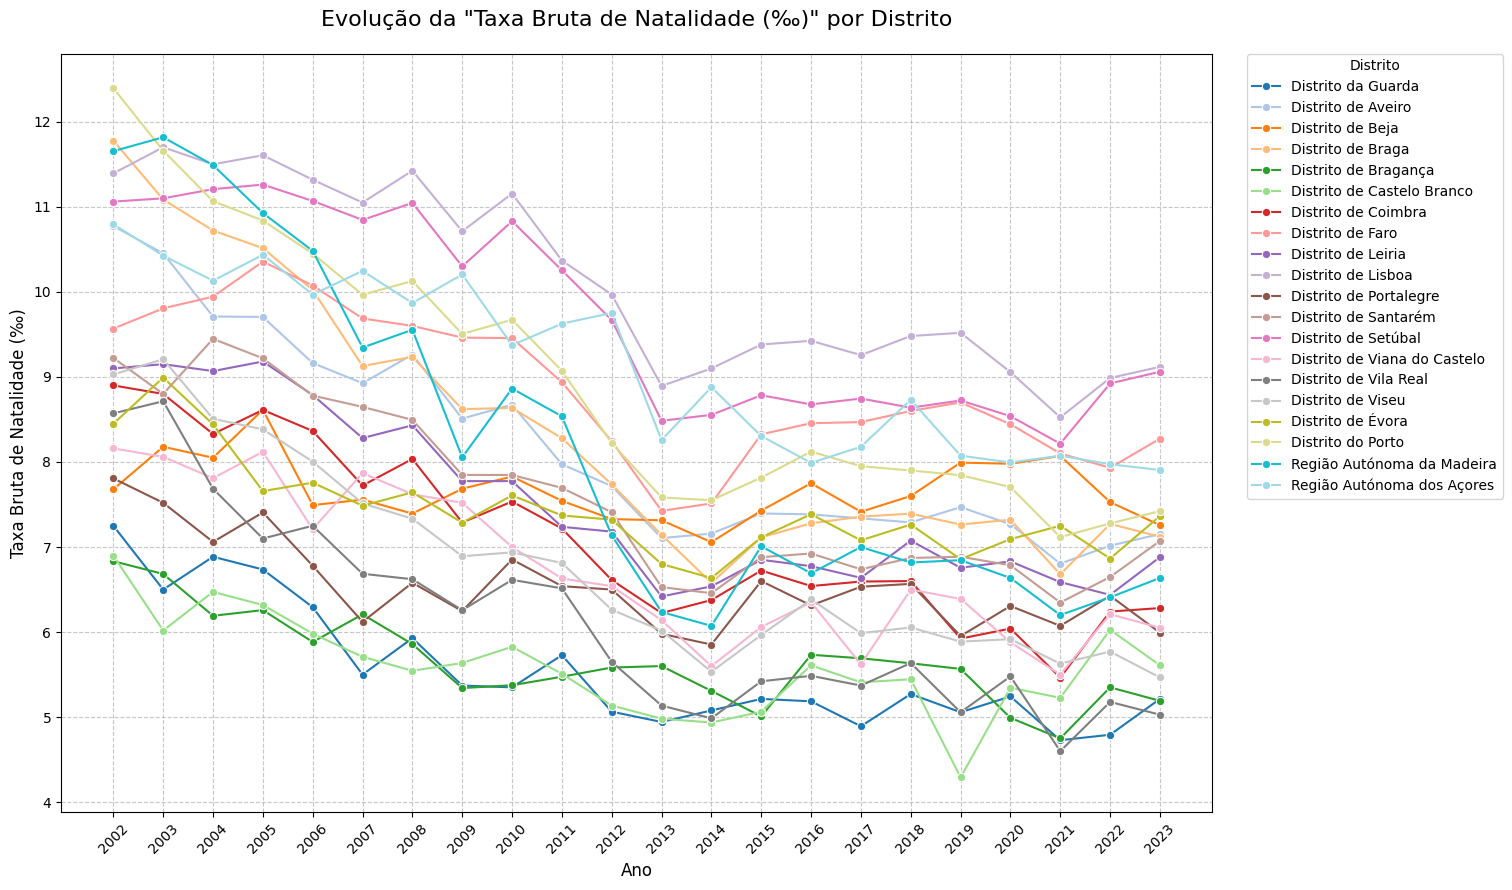

In [63]:
pasta_alvo = "graficos_evolucao_metricas" 

metrica_natalidade = 'Taxa Bruta de Natalidade (‰)'
palette_distritos = 'tab20' 

fig, ax = plt.subplots(figsize=(18, 9))

sns.lineplot(data=df_final, x='Ano', y=metrica_natalidade, hue='Distrito', marker='o', palette=palette_distritos, ax=ax)

ax.legend(title='Distrito', bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)
ax.set_title(f'Evolução da "{metrica_natalidade}" por Distrito', fontsize=16, pad=20)
ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel(metrica_natalidade, fontsize=12)

anos_unicos = sorted(df_final['Ano'].unique())
ax.set_xticks(anos_unicos)
ax.set_xticklabels(anos_unicos, rotation=45) 
ax.grid(True, linestyle='--', alpha=0.7)

fig.tight_layout(rect=[0, 0, 0.85, 1])

nome_base_ficheiro = "evolucao_taxa_bruta_de_natalidade_por_distrito.png"
caminho_completo_ficheiro = os.path.join(pasta_alvo, nome_base_ficheiro)

plt.savefig(caminho_completo_ficheiro, bbox_inches='tight')
print(f"\nGráfico da Taxa Bruta de Natalidade guardado como: {caminho_completo_ficheiro}")
plt.show()
plt.close(fig) 


Gráfico da Taxa Bruta de Mortalidade guardado como: graficos_evolucao_metricas\evolucao_taxa_bruta_de_mortalidade_por_distrito.png


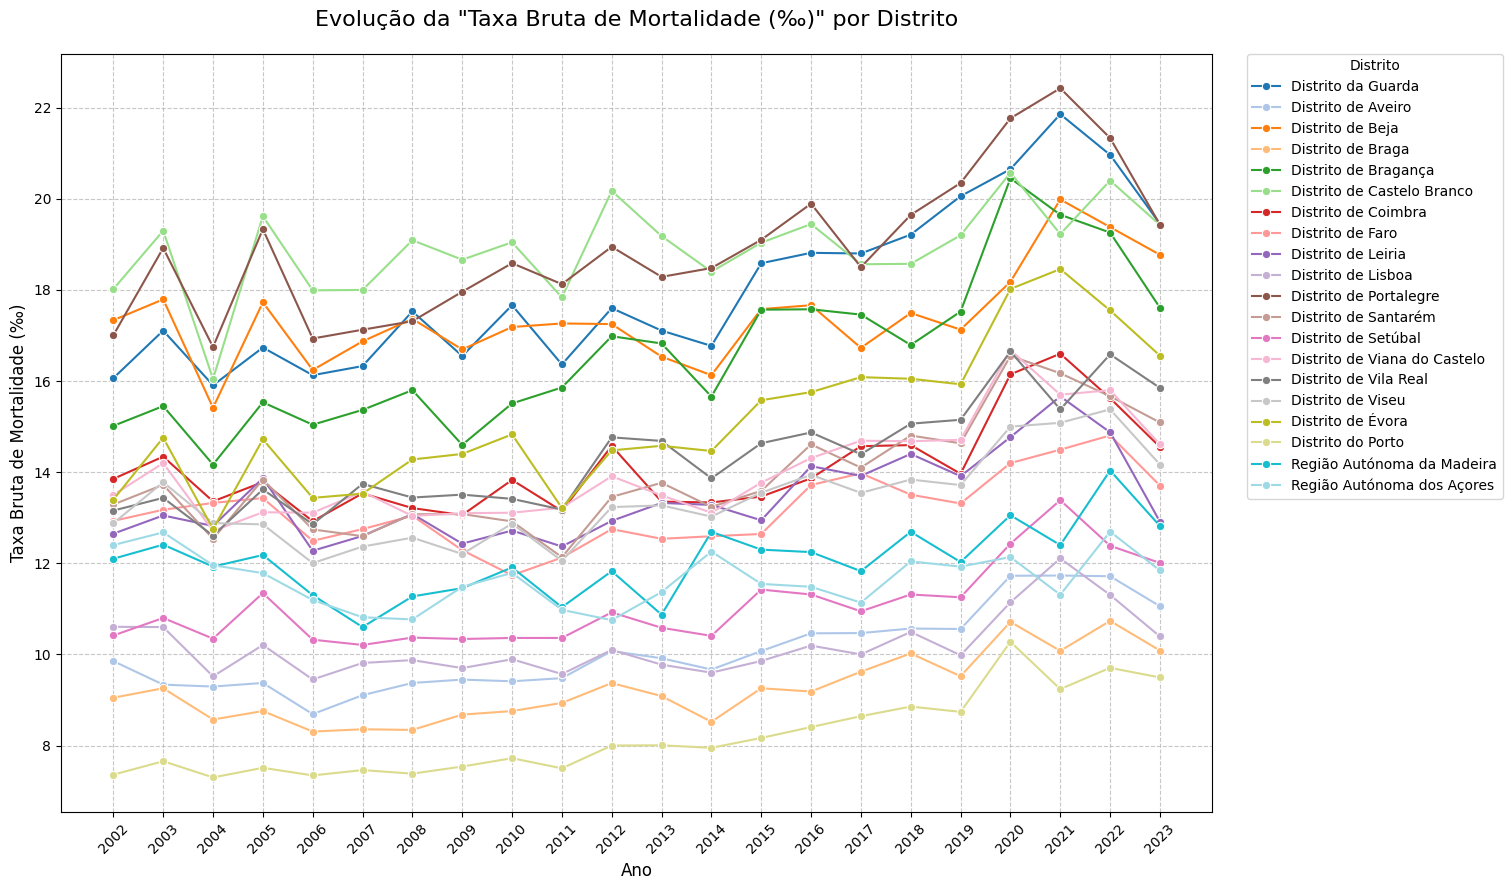

In [64]:
pasta_alvo = "graficos_evolucao_metricas" 

metrica_mortalidade = 'Taxa Bruta de Mortalidade (‰)'
palette_distritos = 'tab20' 

fig, ax = plt.subplots(figsize=(18, 9))

sns.lineplot(data=df_final, x='Ano', y=metrica_mortalidade, hue='Distrito', marker='o', palette=palette_distritos, ax=ax)

ax.legend(title='Distrito', bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)
ax.set_title(f'Evolução da "{metrica_mortalidade}" por Distrito', fontsize=16, pad=20)
ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel(metrica_mortalidade, fontsize=12)

anos_unicos = sorted(df_final['Ano'].unique())
ax.set_xticks(anos_unicos)
ax.set_xticklabels(anos_unicos, rotation=45) 
ax.grid(True, linestyle='--', alpha=0.7)

fig.tight_layout(rect=[0, 0, 0.85, 1])

nome_base_ficheiro = "evolucao_taxa_bruta_de_mortalidade_por_distrito.png"
caminho_completo_ficheiro = os.path.join(pasta_alvo, nome_base_ficheiro)

plt.savefig(caminho_completo_ficheiro, bbox_inches='tight')
print(f"\nGráfico da Taxa Bruta de Mortalidade guardado como: {caminho_completo_ficheiro}")
plt.show()
plt.close() 

#### Metricas de saúde por distrito


A gerar e exibir gráficos combinados para: Distrito da Guarda, Distrito de Aveiro, Distrito de Beja, Distrito de Braga, Distrito de Bragança, Distrito de Castelo Branco, Distrito de Coimbra, Distrito de Faro, Distrito de Leiria, Distrito de Lisboa, Distrito de Portalegre, Distrito de Santarém, Distrito de Setúbal, Distrito de Viana do Castelo, Distrito de Vila Real, Distrito de Viseu, Distrito de Évora, Distrito do Porto, Região Autónoma da Madeira, Região Autónoma dos Açores

--- Processando distrito: Distrito da Guarda ---
Gráfico para Distrito da Guarda guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_da_guarda.png


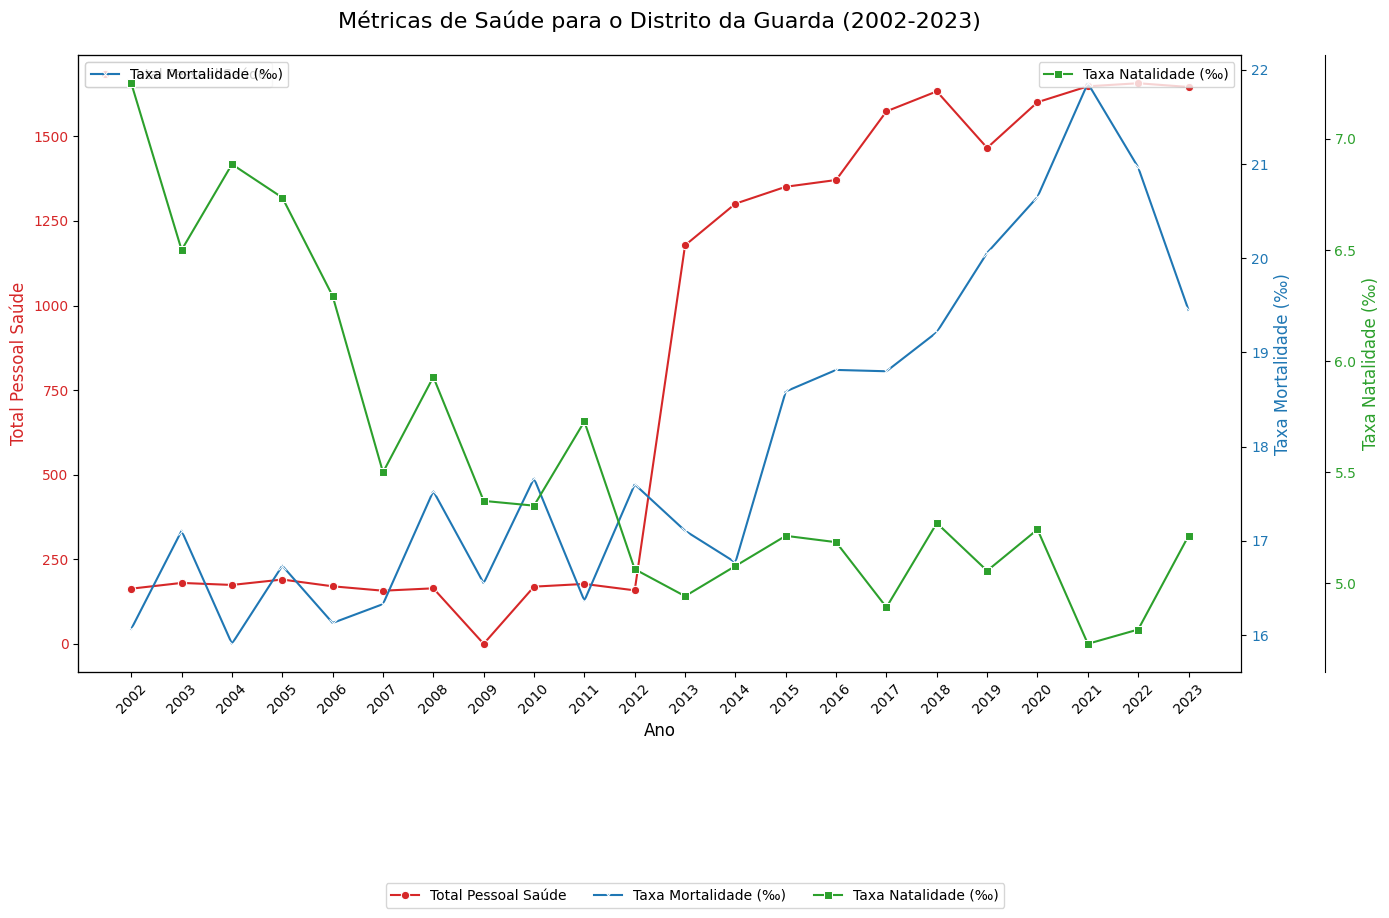


--- Processando distrito: Distrito de Aveiro ---
Gráfico para Distrito de Aveiro guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_aveiro.png


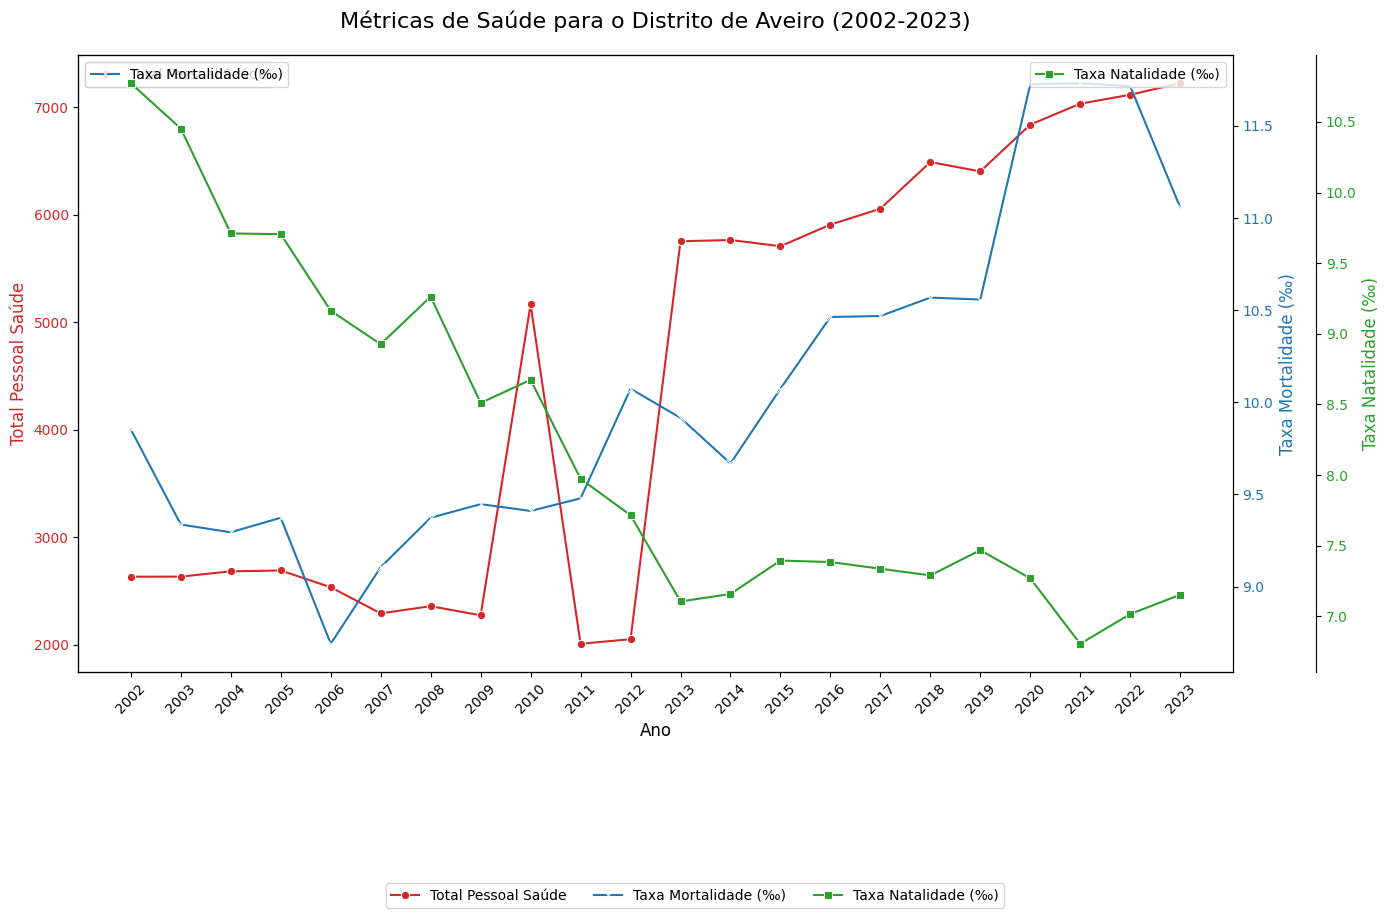


--- Processando distrito: Distrito de Beja ---
Gráfico para Distrito de Beja guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_beja.png


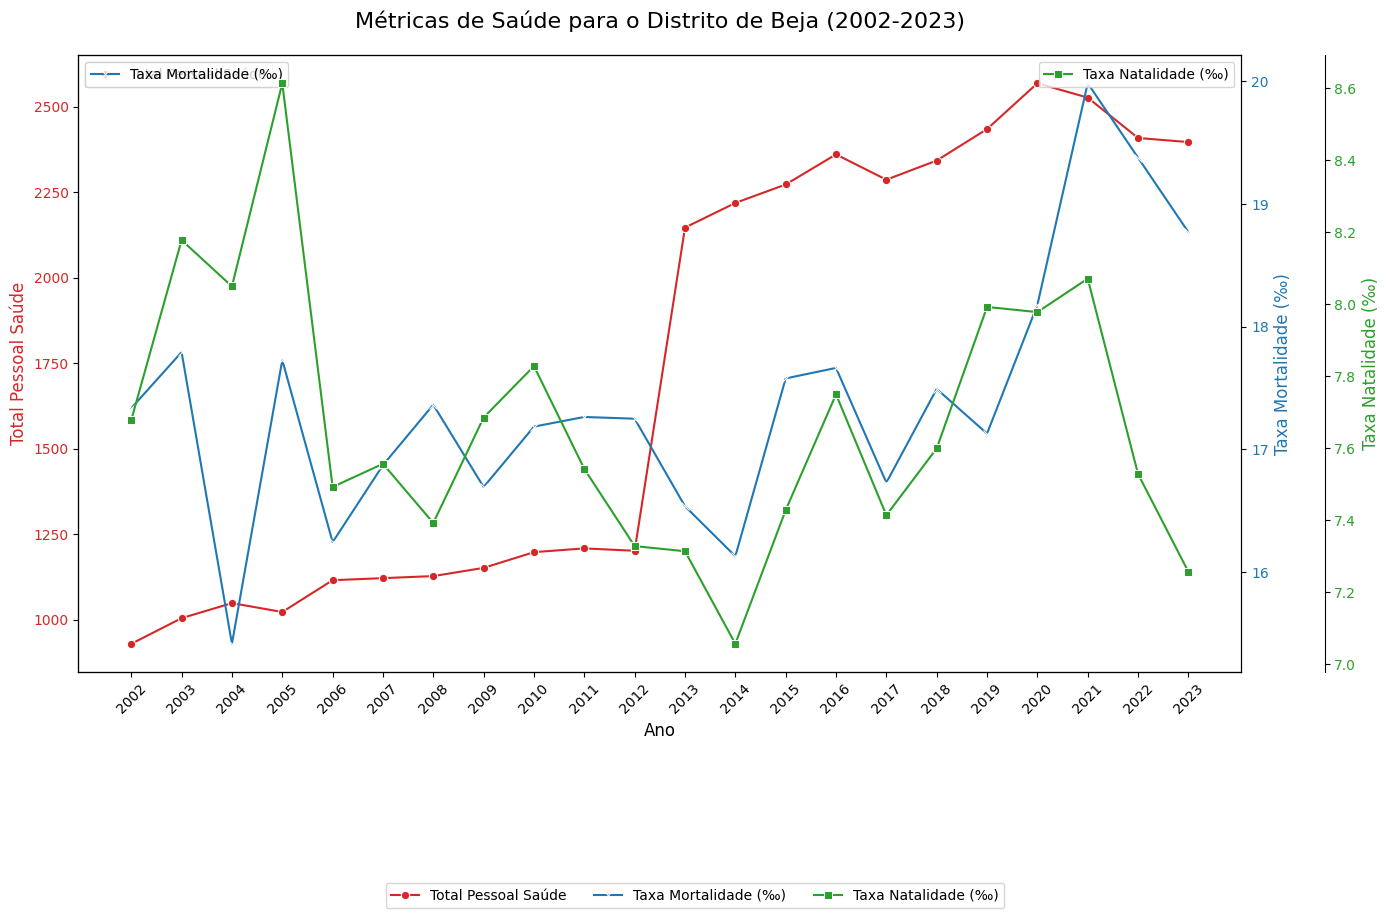


--- Processando distrito: Distrito de Braga ---
Gráfico para Distrito de Braga guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_braga.png


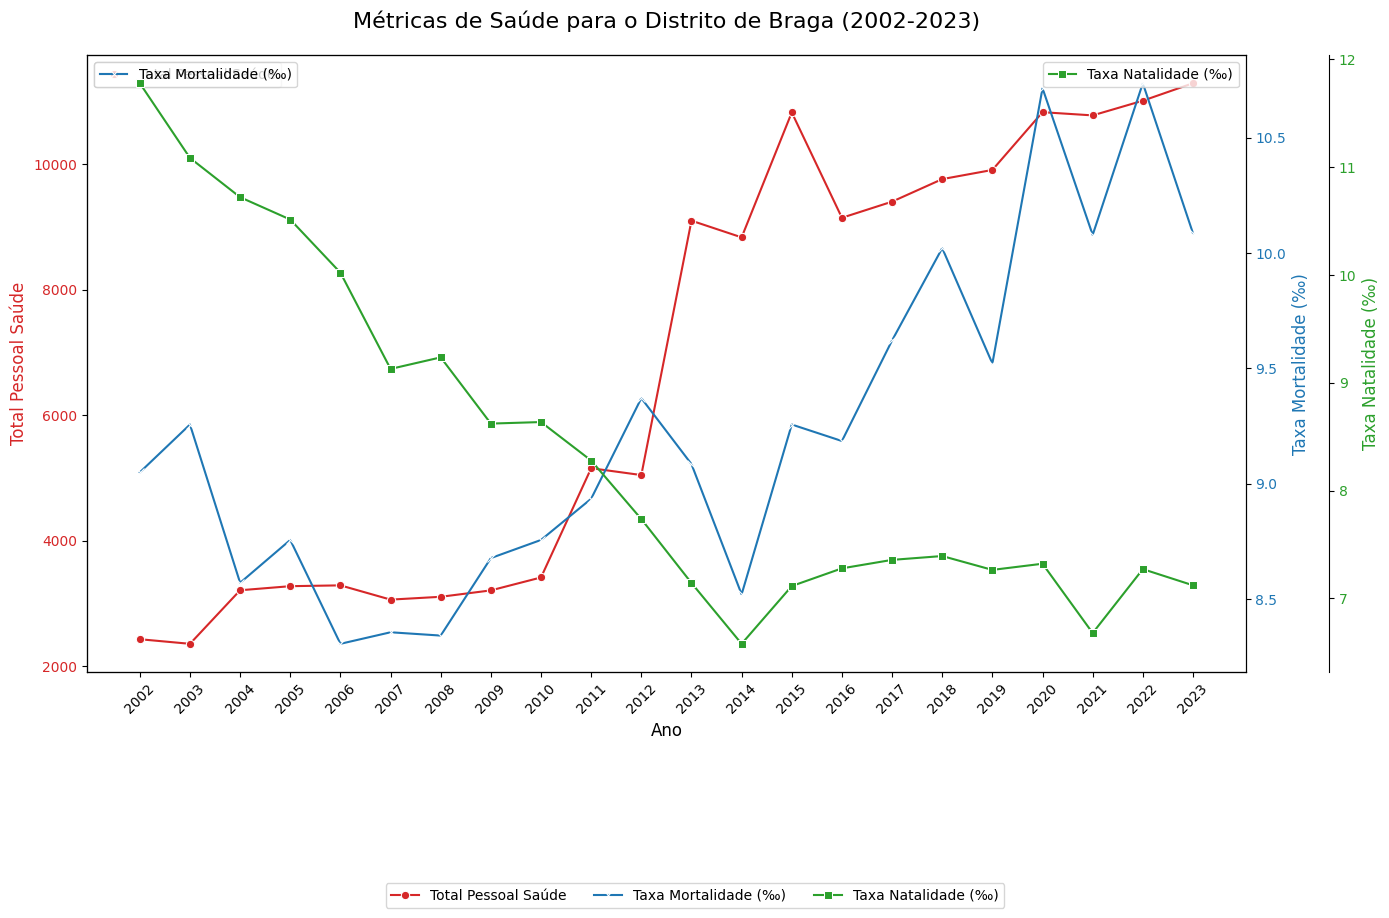


--- Processando distrito: Distrito de Bragança ---
Gráfico para Distrito de Bragança guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_bragan_a.png


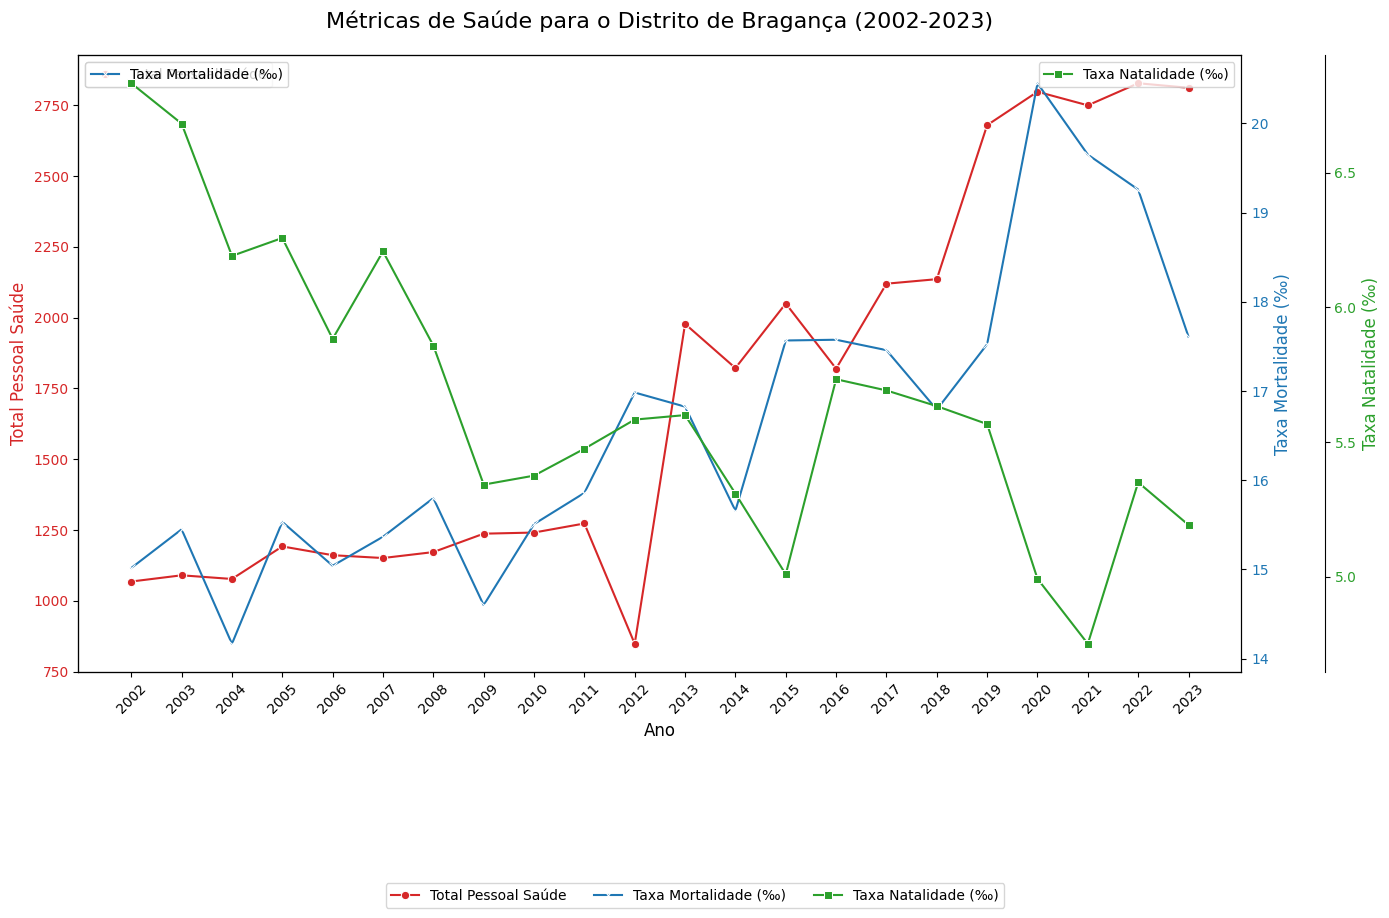


--- Processando distrito: Distrito de Castelo Branco ---
Gráfico para Distrito de Castelo Branco guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_castelo_branco.png


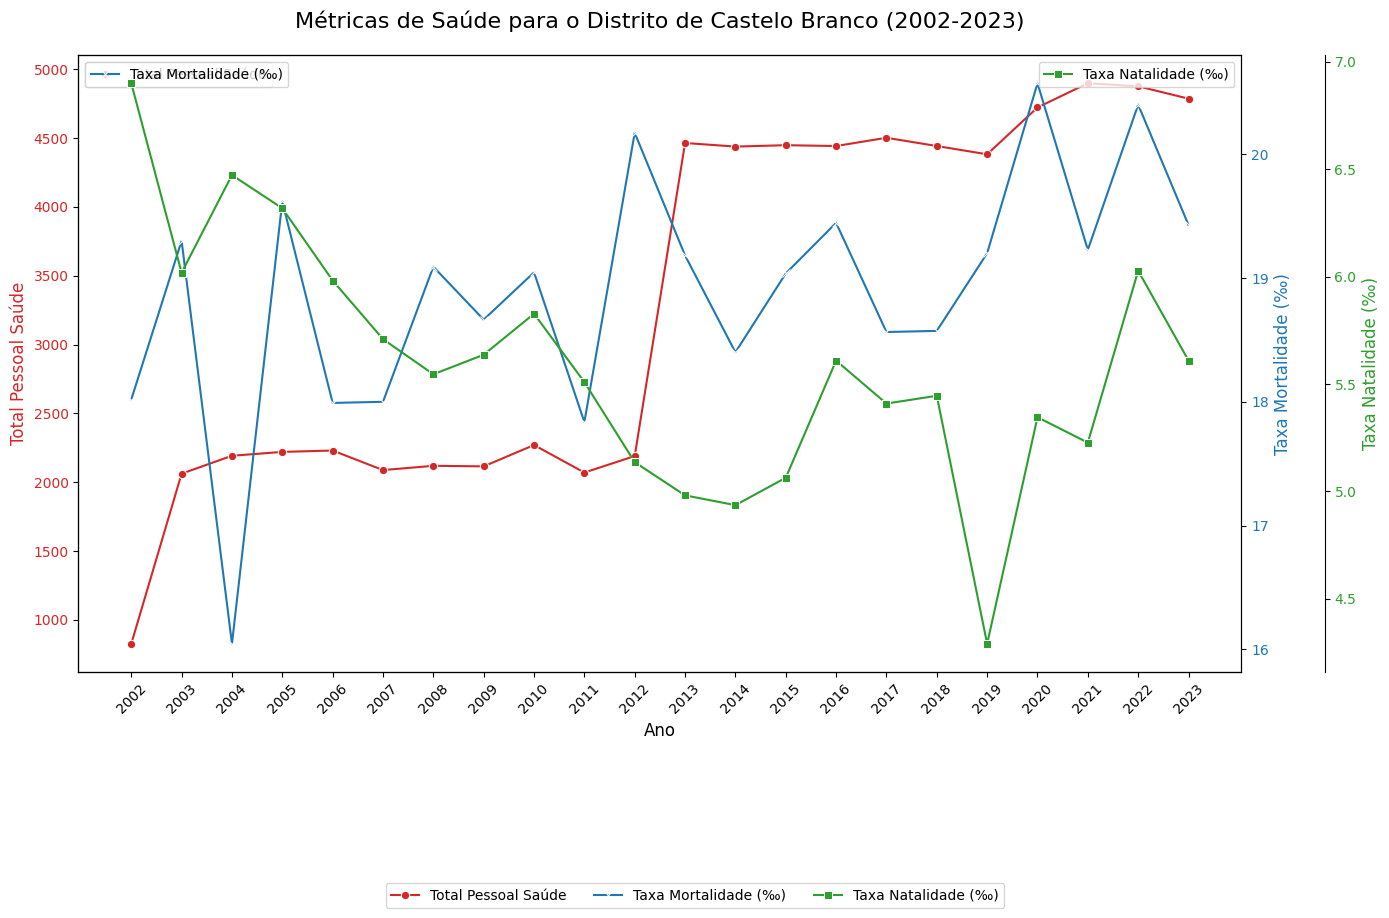


--- Processando distrito: Distrito de Coimbra ---
Gráfico para Distrito de Coimbra guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_coimbra.png


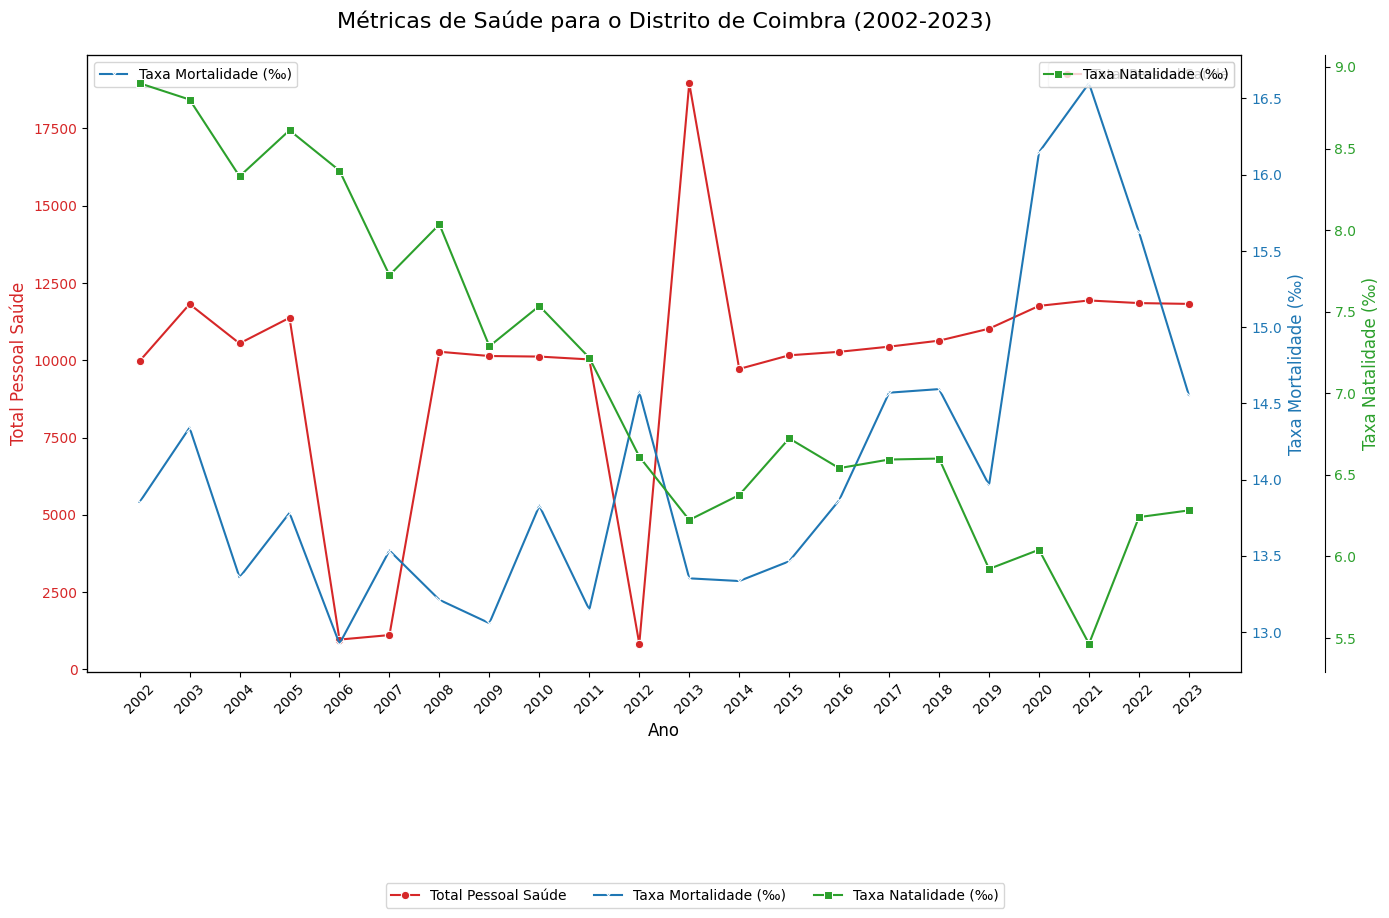


--- Processando distrito: Distrito de Faro ---
Gráfico para Distrito de Faro guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_faro.png


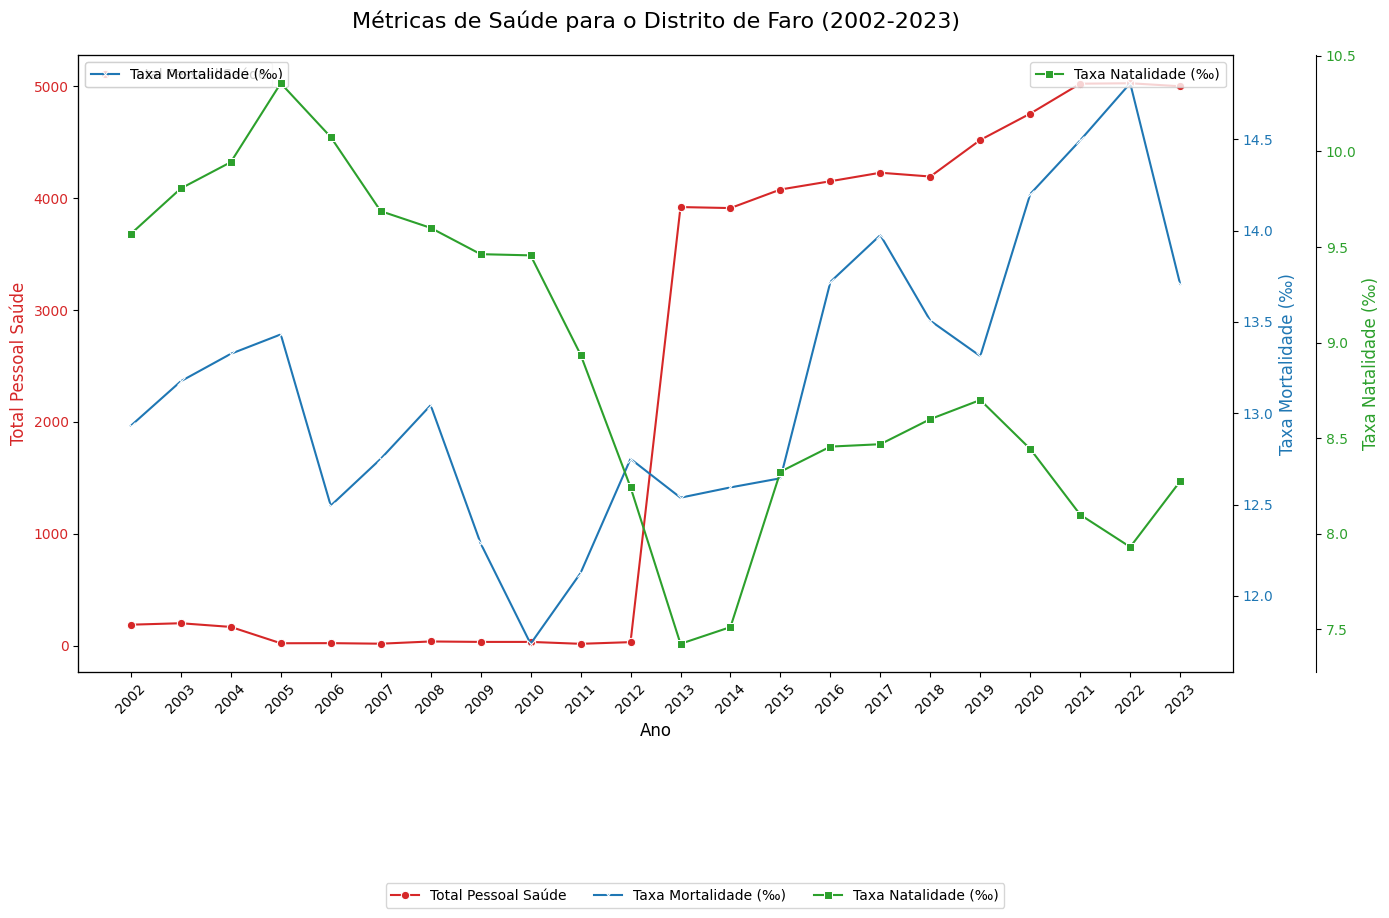


--- Processando distrito: Distrito de Leiria ---
Gráfico para Distrito de Leiria guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_leiria.png


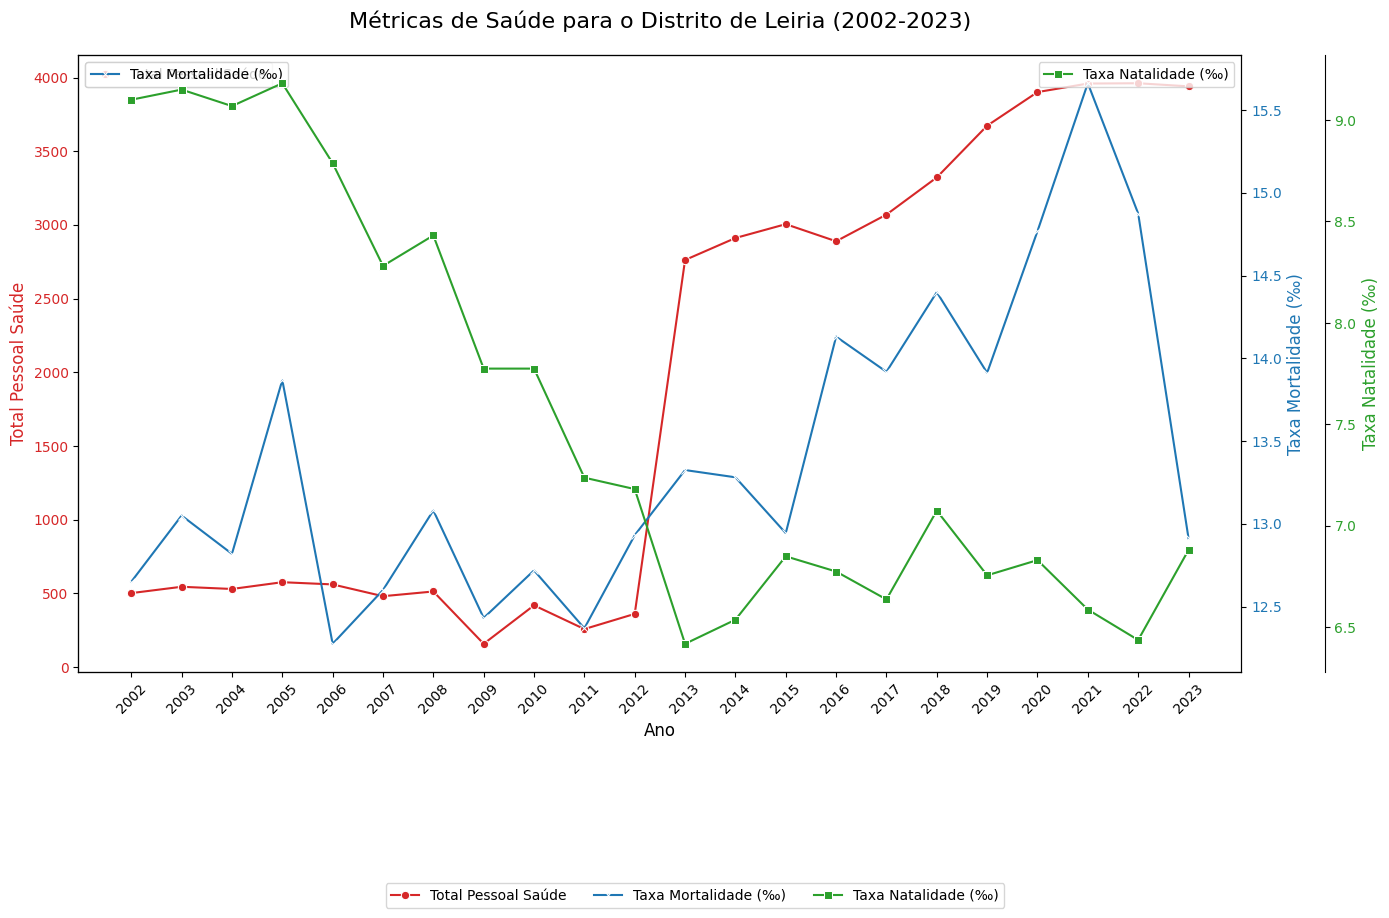


--- Processando distrito: Distrito de Lisboa ---
Gráfico para Distrito de Lisboa guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_lisboa.png


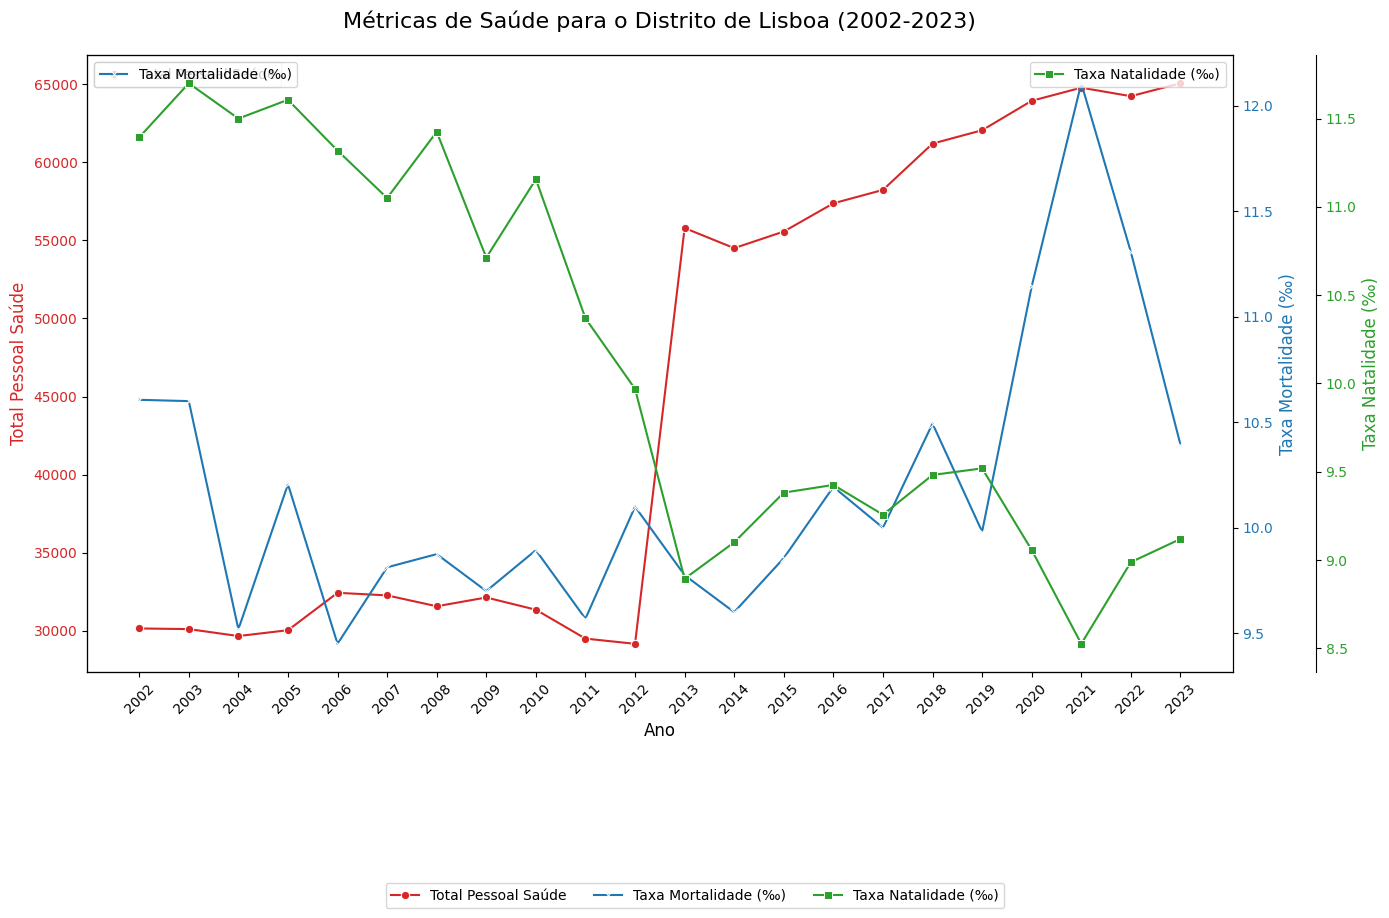


--- Processando distrito: Distrito de Portalegre ---
Gráfico para Distrito de Portalegre guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_portalegre.png


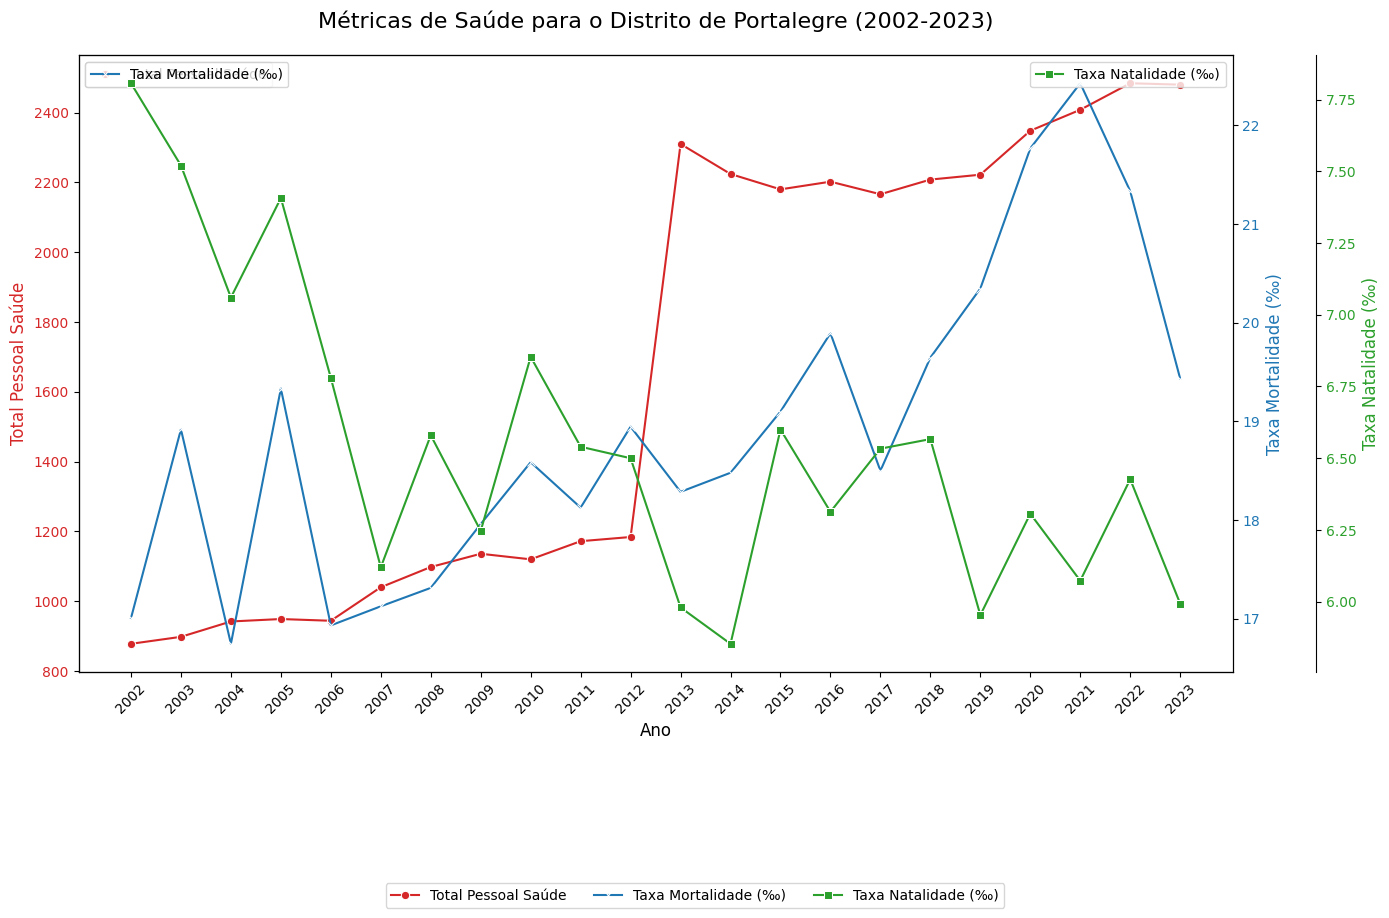


--- Processando distrito: Distrito de Santarém ---
Gráfico para Distrito de Santarém guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_santar_m.png


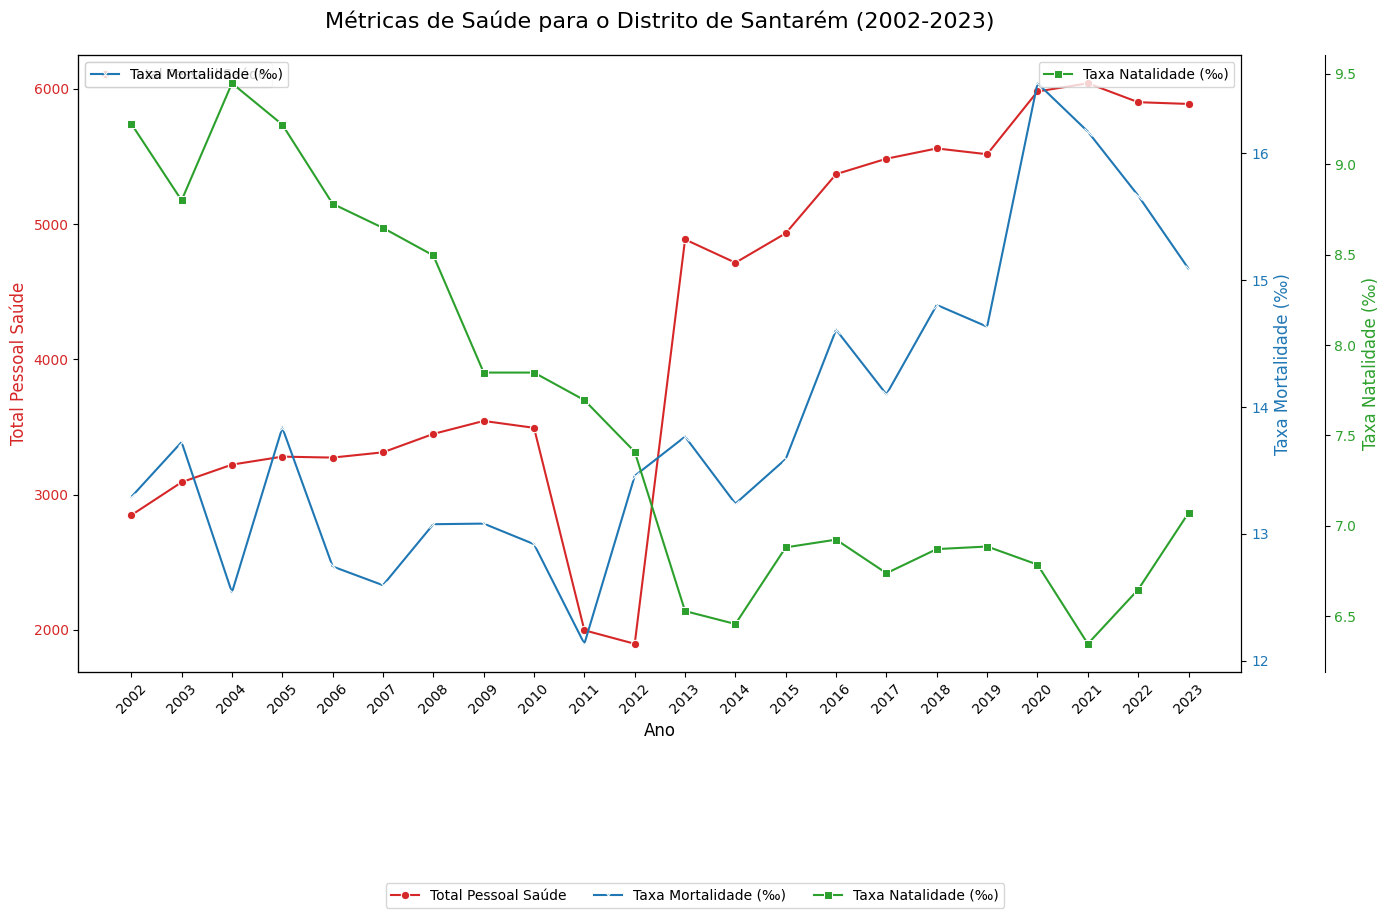


--- Processando distrito: Distrito de Setúbal ---
Gráfico para Distrito de Setúbal guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_set_bal.png


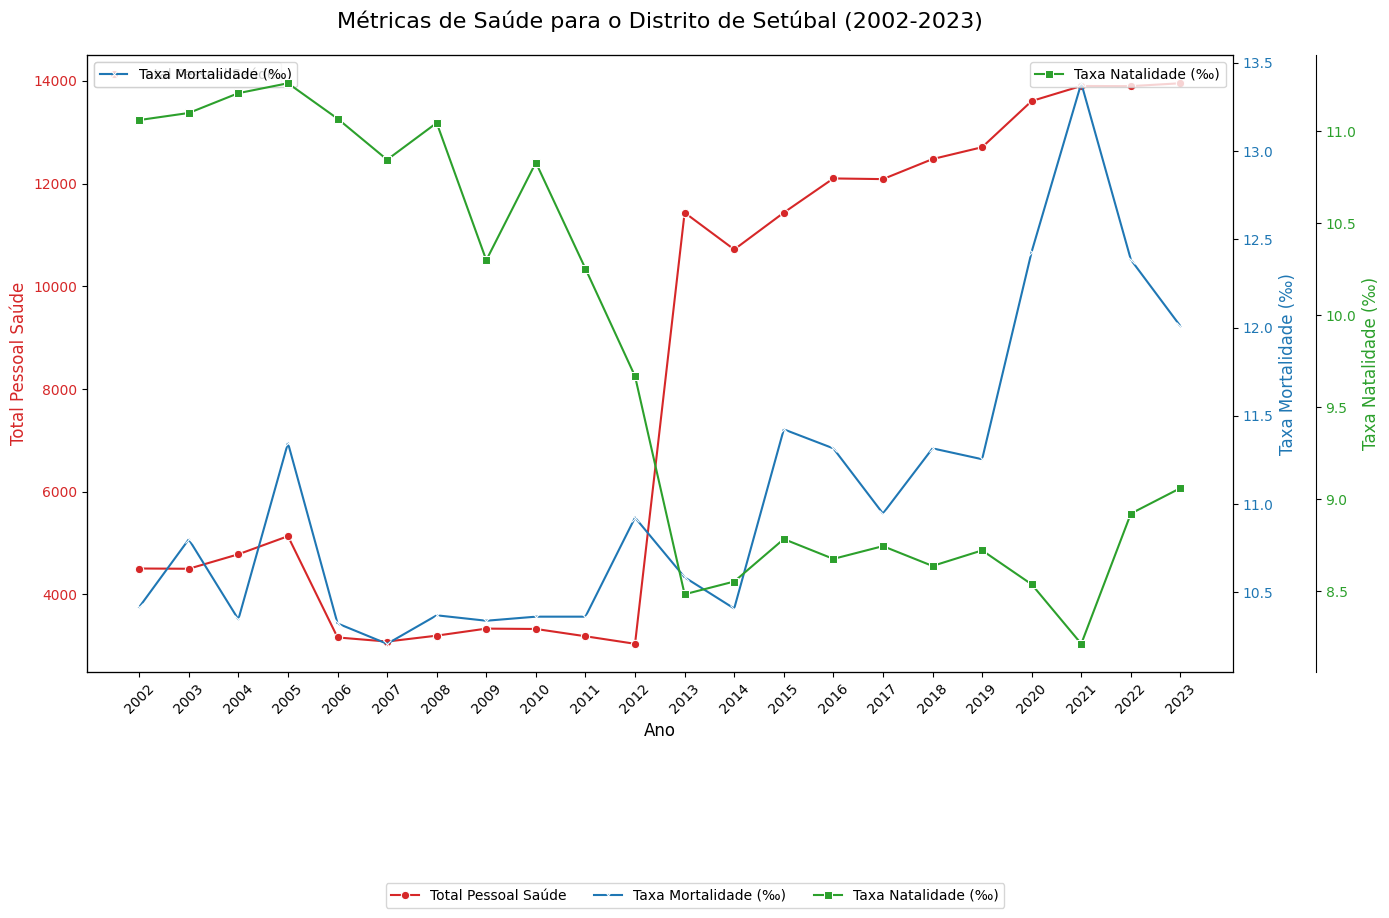


--- Processando distrito: Distrito de Viana do Castelo ---
Gráfico para Distrito de Viana do Castelo guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_viana_do_castelo.png


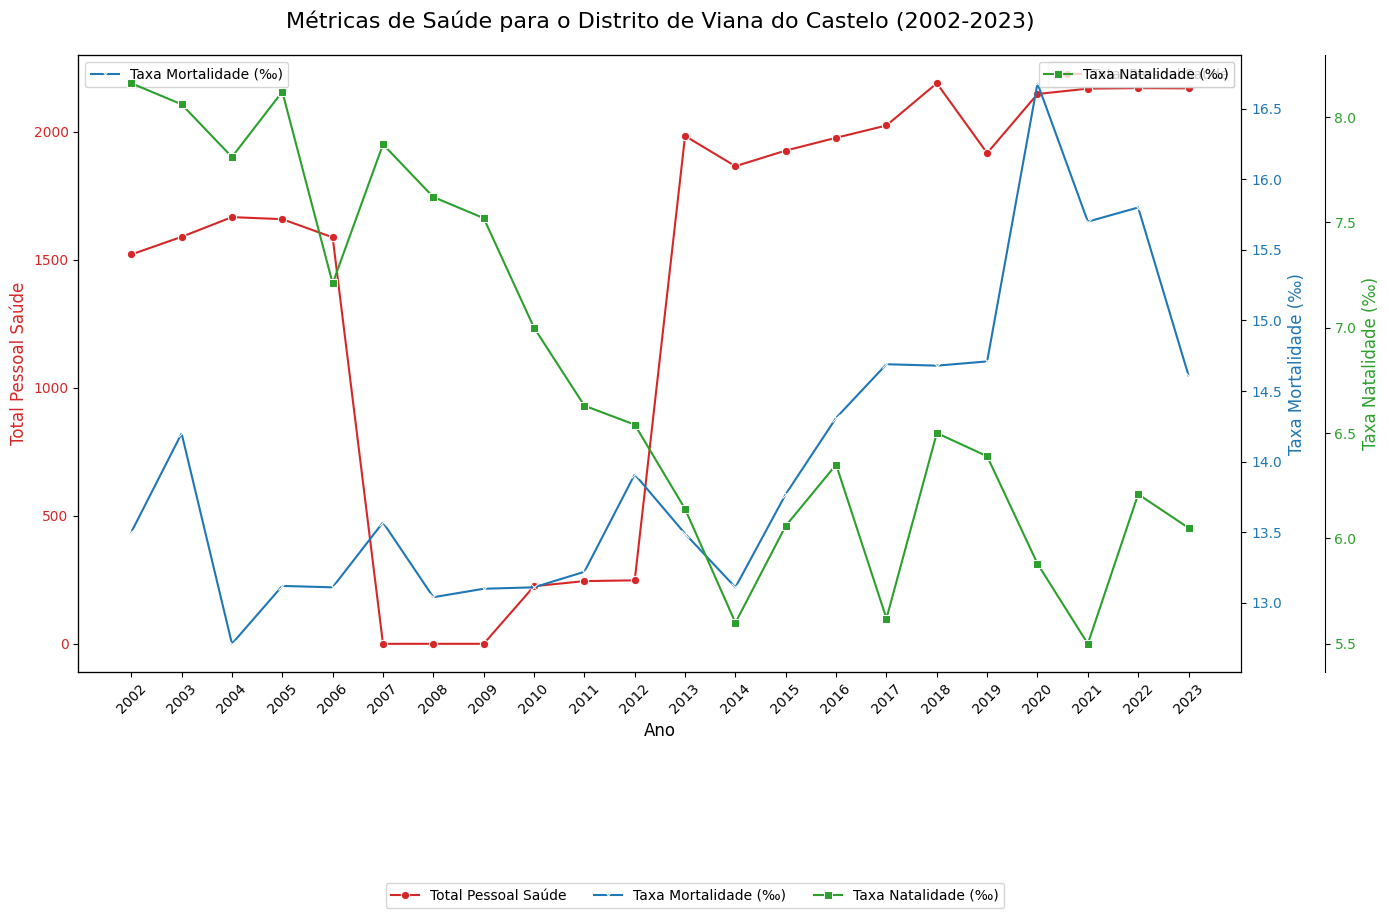


--- Processando distrito: Distrito de Vila Real ---
Gráfico para Distrito de Vila Real guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_vila_real.png


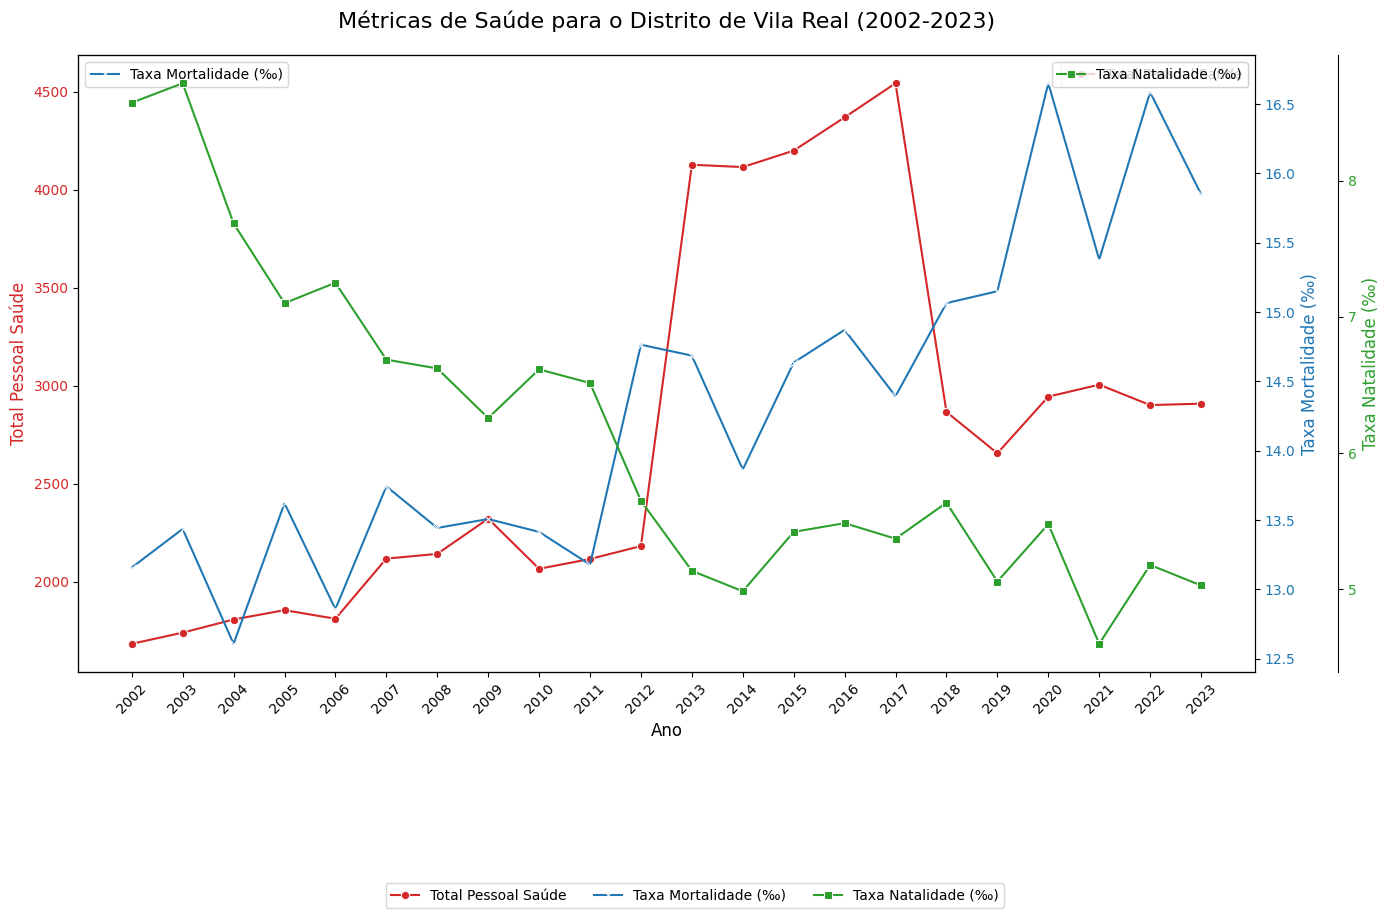


--- Processando distrito: Distrito de Viseu ---
Gráfico para Distrito de Viseu guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_viseu.png


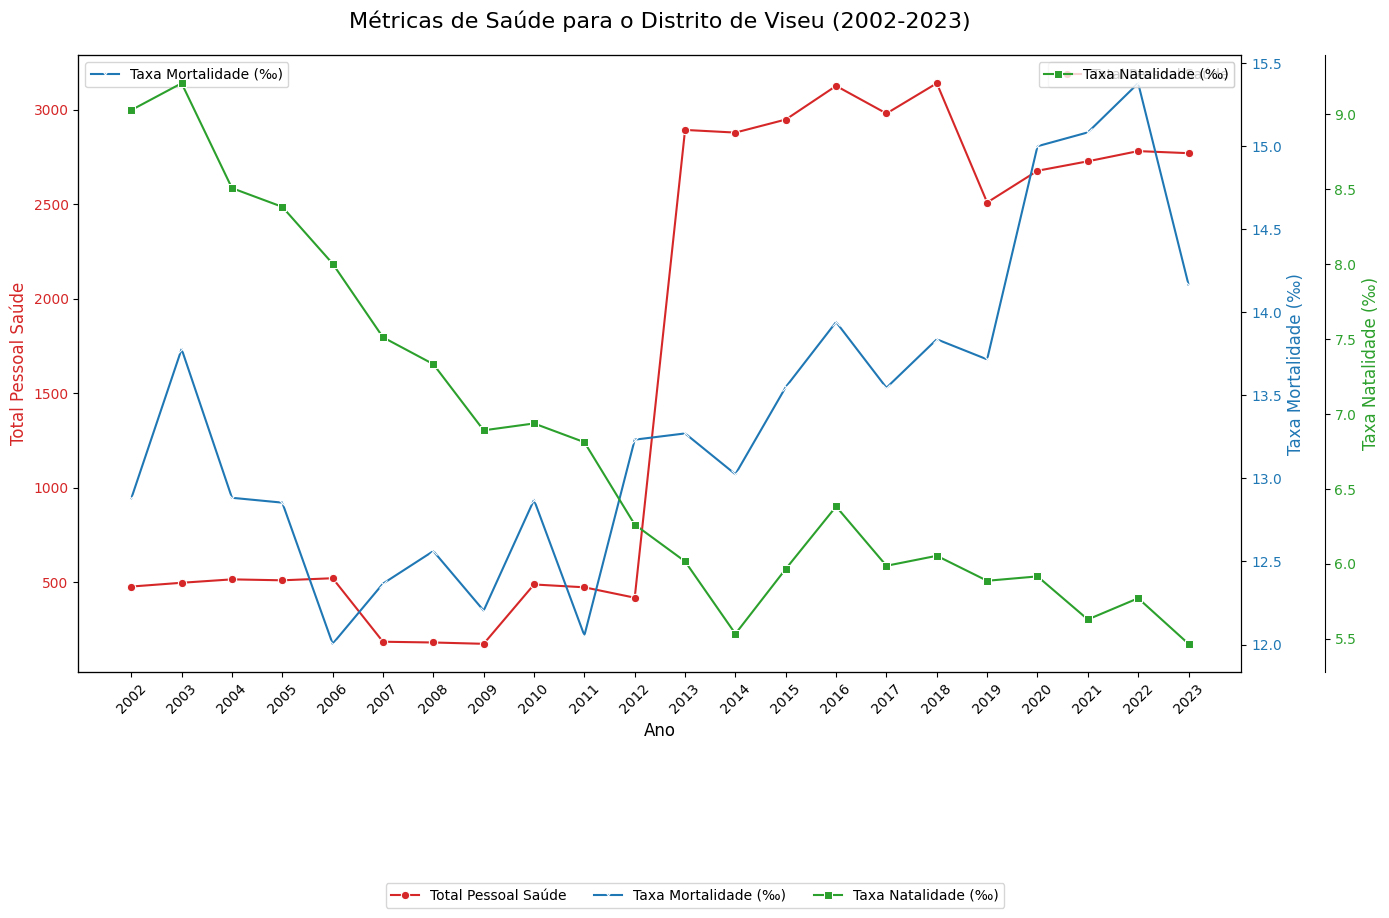


--- Processando distrito: Distrito de Évora ---
Gráfico para Distrito de Évora guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_de_vora.png


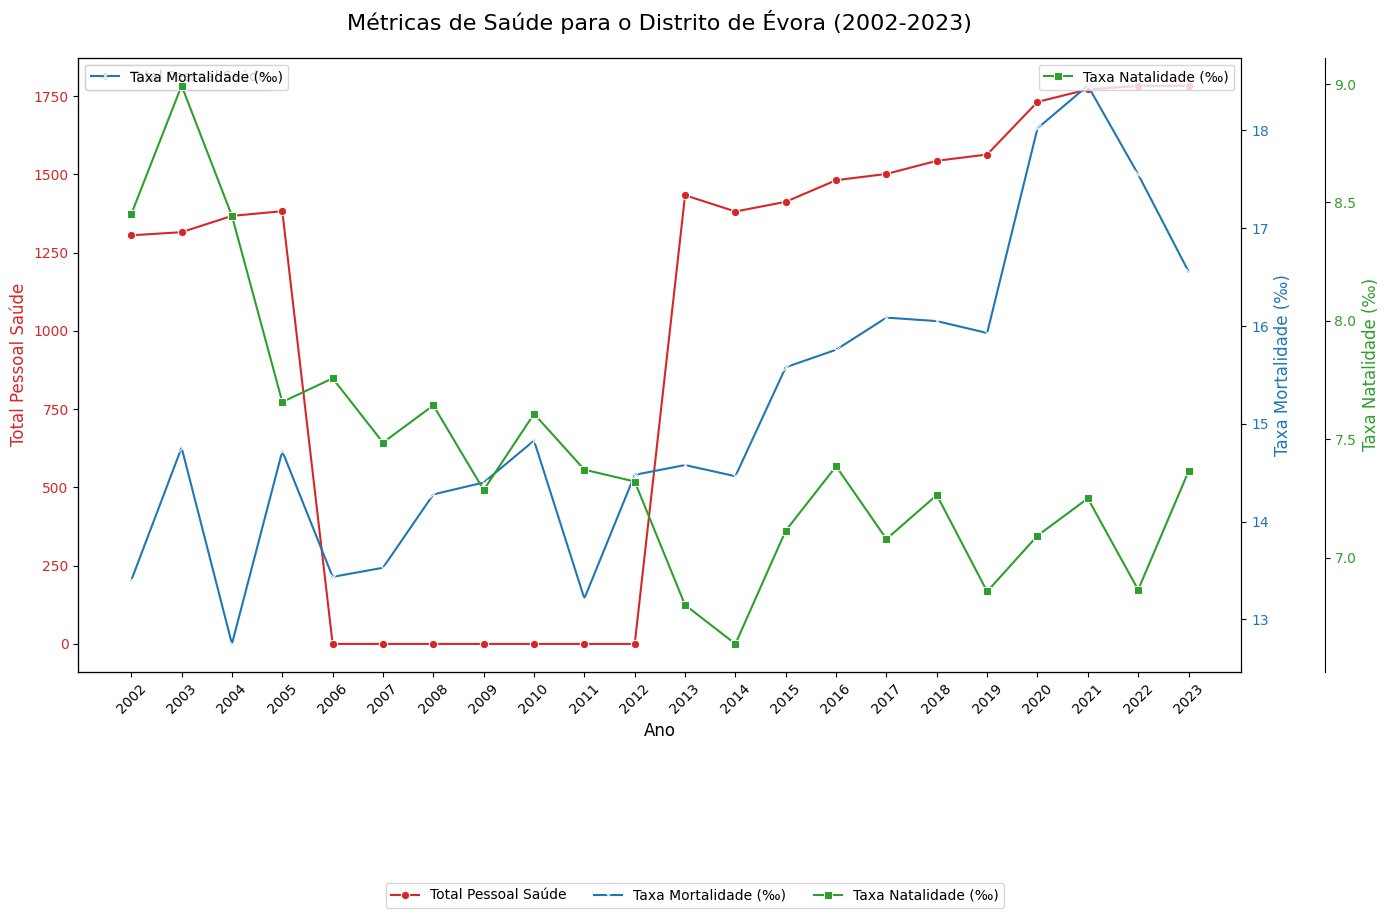


--- Processando distrito: Distrito do Porto ---
Gráfico para Distrito do Porto guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_distrito_do_porto.png


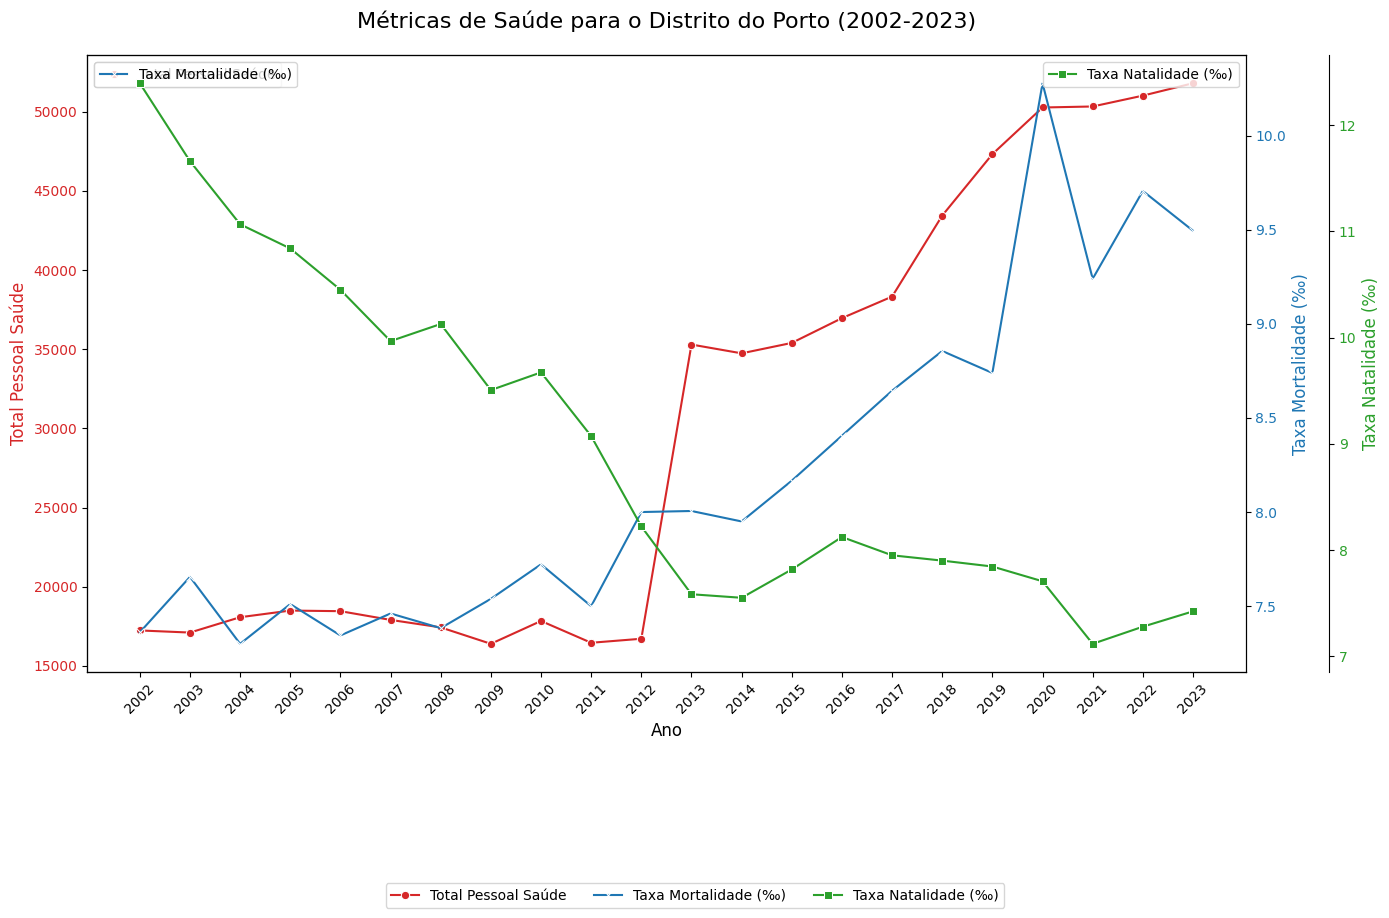


--- Processando distrito: Região Autónoma da Madeira ---
Gráfico para Região Autónoma da Madeira guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_regi_o_aut_noma_da_madeira.png


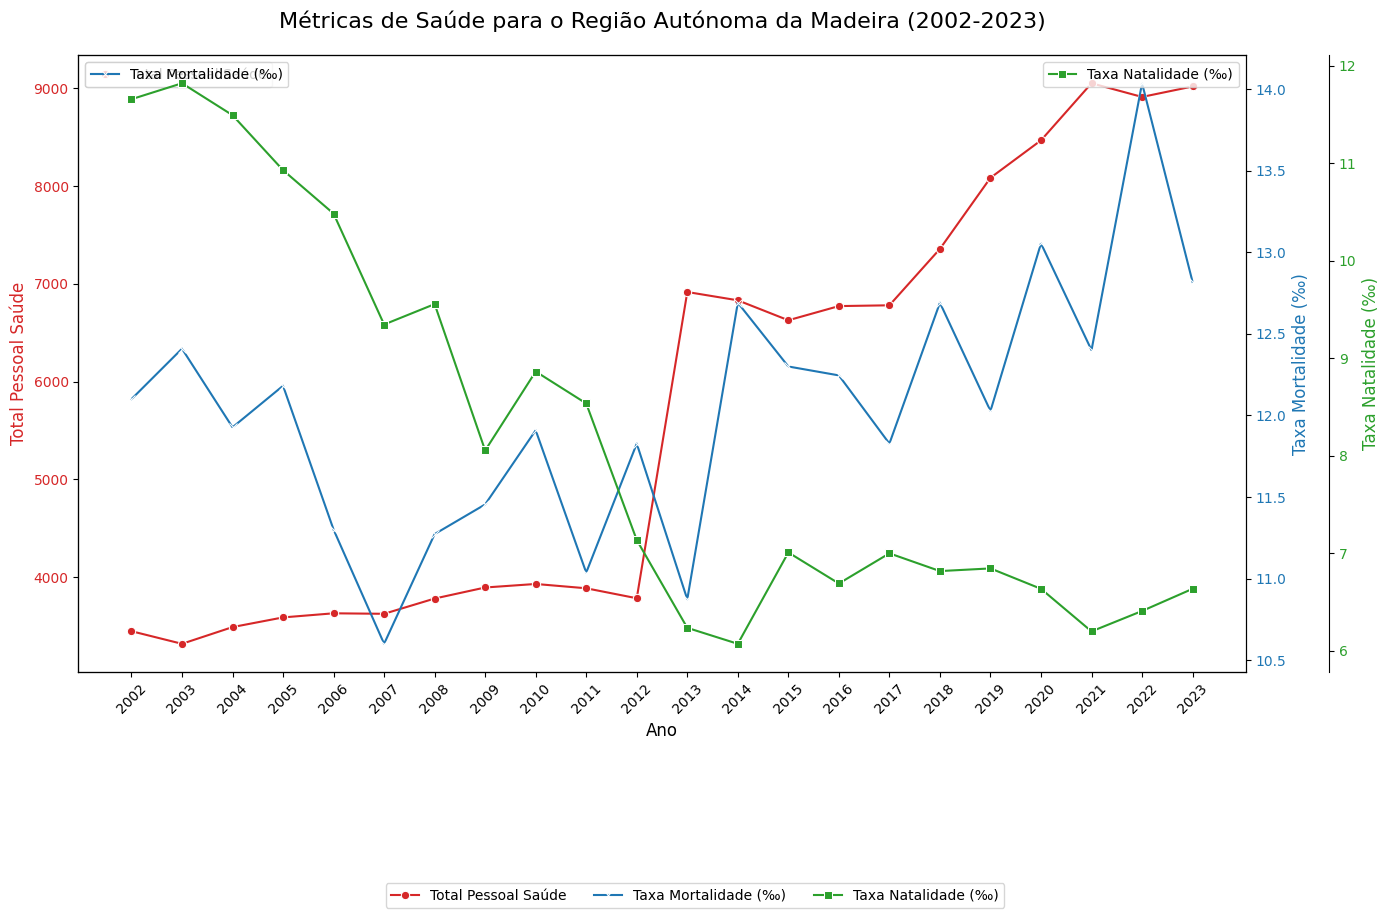


--- Processando distrito: Região Autónoma dos Açores ---
Gráfico para Região Autónoma dos Açores guardado como: graficos_metricas_de_saude_por_distrito\metricas_saude_estilo_especifico_regi_o_aut_noma_dos_a_ores.png


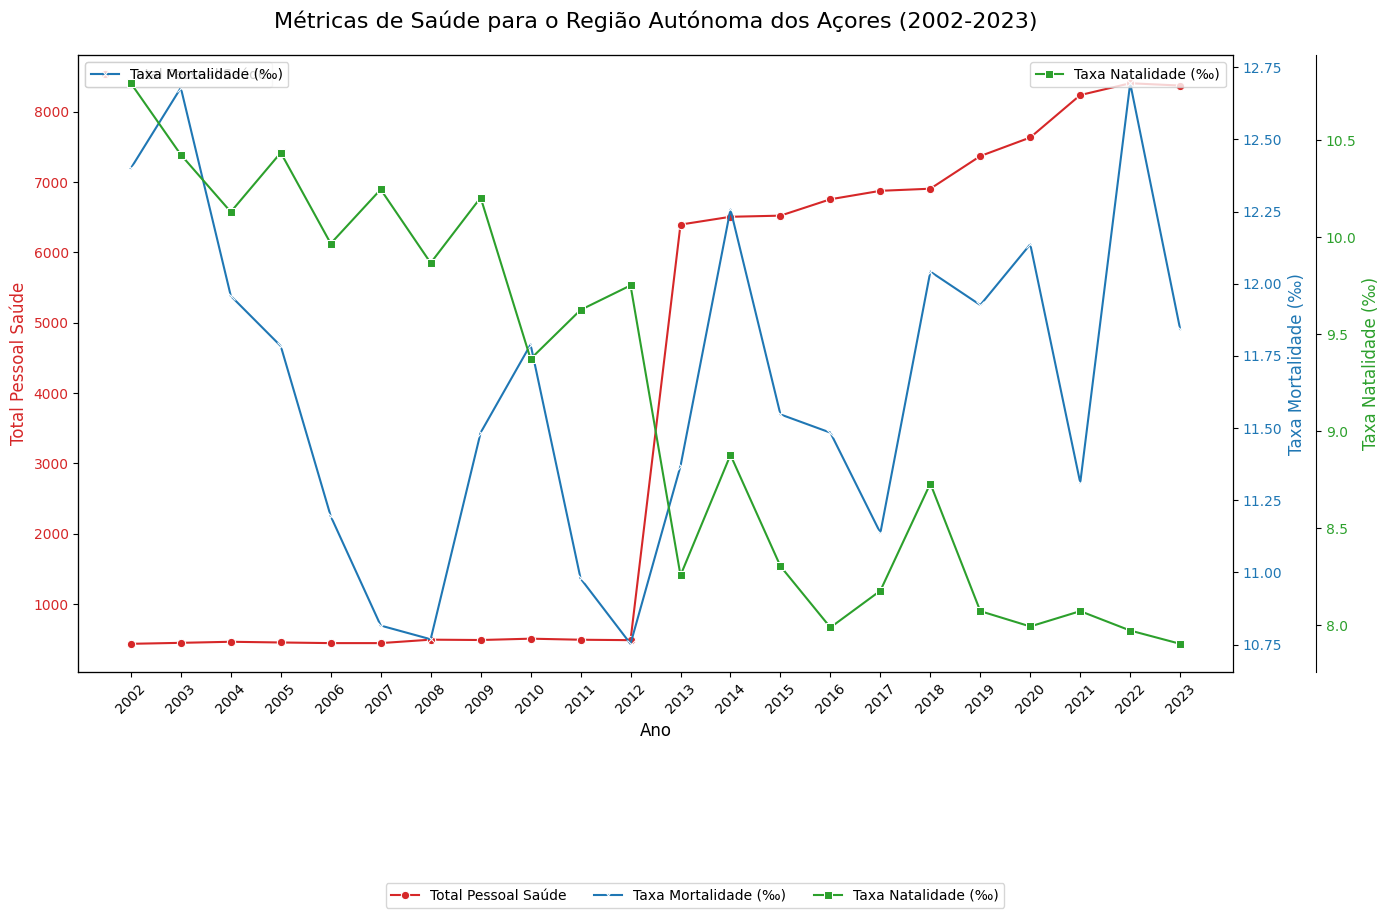

In [66]:
pasta_graficos = "graficos_metricas_de_saude_por_distrito"
if not os.path.exists(pasta_graficos):
    os.makedirs(pasta_graficos)
    print(f"Pasta '{pasta_graficos}' criada para guardar os gráficos.")

distritos_unicos = sorted(df_final['Distrito'].unique())
print(f"\nA gerar e exibir gráficos combinados para: {', '.join(distritos_unicos)}")

for distrito_alvo in distritos_unicos:
    print(f"\n--- Processando distrito: {distrito_alvo} ---")
    df_distrito_especifico = df_final[df_final['Distrito'] == distrito_alvo].copy()

    if not df_distrito_especifico.empty:
        df_distrito_especifico.sort_values('Ano', inplace=True)
        
        fig, ax1 = plt.subplots(figsize=(14, 8)) 

        # Eixo 1: Total Pessoal Saúde
        cor_total = 'tab:red'
        ax1.set_xlabel('Ano', fontsize=12) 
        ax1.set_ylabel('Total Pessoal Saúde', color=cor_total, fontsize=12) 
        sns.lineplot(data=df_distrito_especifico, x='Ano', y='Total', ax=ax1, color=cor_total, marker='o', label='Total Pessoal Saúde')
        ax1.tick_params(axis='y', labelcolor=cor_total)
        anos_unicos_distrito = sorted(df_distrito_especifico['Ano'].unique())
        ax1.set_xticks(anos_unicos_distrito)
        ax1.set_xticklabels(anos_unicos_distrito, rotation=45)

        # Eixo 2: Taxa Bruta de Mortalidade
        ax2 = ax1.twinx() 
        cor_mortalidade = 'tab:blue' 
        ax2.set_ylabel('Taxa Mortalidade (‰)', color=cor_mortalidade, fontsize=12) 
        sns.lineplot(data=df_distrito_especifico, x='Ano', y='Taxa Bruta de Mortalidade (‰)', ax=ax2, color=cor_mortalidade, marker='x', label='Taxa Mortalidade (‰)')
        ax2.tick_params(axis='y', labelcolor=cor_mortalidade)

        # Eixo 3: Taxa Bruta de Natalidade
        ax3 = ax1.twinx()
        ax3.spines["right"].set_position(("outward", 60)) 
        cor_natalidade = 'tab:green' 
        ax3.set_ylabel('Taxa Natalidade (‰)', color=cor_natalidade, fontsize=12) 
        sns.lineplot(data=df_distrito_especifico, x='Ano', y='Taxa Bruta de Natalidade (‰)', ax=ax3, color=cor_natalidade, marker='s', label='Taxa Natalidade (‰)')
        ax3.tick_params(axis='y', labelcolor=cor_natalidade)
        
        ano_min = df_distrito_especifico['Ano'].min()
        ano_max = df_distrito_especifico['Ano'].max()
        plt.title(f'Métricas de Saúde para o {distrito_alvo} ({ano_min}-{ano_max})', fontsize=16, pad=20) 
        
        handles, labels = [], []
        for ax_leg in [ax1, ax2, ax3]:
            for h, l in zip(*ax_leg.get_legend_handles_labels()):
                if l not in labels: # Evitar legendas duplicadas
                    handles.append(h)
                    labels.append(l)
        
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

        fig.tight_layout(rect=[0, 0.05, 1, 1]) 
        
        nome_distrito_limpo = distrito_alvo.replace(' ', '_').lower()
        caracteres_a_remover = "().,[]ãáàâçéèêíìîóòôõúùûü" 
        tabela_traducao = str.maketrans(caracteres_a_remover, "_"*len(caracteres_a_remover), "'\"") 
        nome_distrito_limpo = nome_distrito_limpo.translate(tabela_traducao)
        nome_distrito_limpo = "".join(c if c.isalnum() or c == '_' else "_" for c in nome_distrito_limpo)
        nome_distrito_limpo = nome_distrito_limpo.replace("___", "_").replace("__", "_")

        nome_ficheiro_distrito = os.path.join(pasta_graficos, f"metricas_saude_estilo_especifico_{nome_distrito_limpo}.png")
        plt.savefig(nome_ficheiro_distrito, bbox_inches='tight') # Adicionado bbox_inches='tight'
        print(f"Gráfico para {distrito_alvo} guardado como: {nome_ficheiro_distrito}")
        plt.show()
        plt.close() 
    